## 05 模型实现

在前面的 Notebook 中，我们已经完成了数据预处理和准备工作。接下来，我们将实现并训练5种不同的机器学习模型，模型复杂度逐步增加，以便比较它们在文本分类任务中的表现。

首先，我们从本地文件中读取数据集，包括分词后的数据集 （`*_seg`）与词元化后的数据集（`*_tok`），以及构建好的词汇表 `vocab`。

In [1]:
from pandas import DataFrame
from MyModule import load_vocab, load_data

train_seg = load_data('data/train_segmented_final.txt', sep='<sp>', is_segmented=True)
val_seg = load_data('data/val_segmented_final.txt', sep='<sp>', is_segmented=True)
test_seg = load_data('data/test_segmented_final.txt', sep='<sp>', is_segmented=True)

train_tok = load_data('data/train_tokenized_final.txt', sep=',', is_tokenized=True)
val_tok = load_data('data/val_tokenized_final.txt', sep=',', is_tokenized=True)
test_tok = load_data('data/test_tokenized_final.txt', sep=',', is_tokenized=True)

vocab = load_vocab('data/vocab_final.txt')

e:\anaconda3\envs\nlpllma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 重要概念与机制介绍

本次项目中，我们实现的模型均基于神经网络架构，因此它们的训练、验证与测试过程都遵循深度学习模型的标准流程。

下面，我们将介绍一些在通用标准流程中涉及的重要概念与机制，这些内容有助于理解后续模型的实现与训练过程。

#### 1. 类别权重（Class Weight）
在 `02Feature Engineering and Data Analysis.ipynb` 中，我们已经观察到数据集标签的分布不平衡情况。在 `03Data Augmentation.ipynb` 中，我们通过回译的方法对训练集进行了数据增强，以缓解类别不平衡的问题。然而，两个定量指标（IR 与 CV）均表明：增强后数据集仍有一定的不平衡性，可能会对模型的训练带来影响。

为了进一步缓解由数据不平衡对模型学习造成的干扰，我们在本 Notebook 中引入类别权重（Class Weight）方法。

类别权重方法是指：在计算损失函数时，为不同类别的样本分配不同的权重，从而使得模型在训练过程中更加关注那些样本较少的类别。具体来说，我们根据每个类别在训练集中的样本数量，计算出每个类别的权重，样本数量越少的类别，其对应的权重越大。下面的代码展示了如何计算类别权重：

In [2]:
import torch

def class_weights(train_data: DataFrame):  #@save
    """计算类别权重，用于损失函数中的加权"""
    label_counts = train_data["label"].value_counts().values
    class_counts = torch.tensor(label_counts, dtype=torch.float)
    weights = torch.sum(class_counts) / (len(class_counts) * class_counts)
    return weights

在后续训练时，只需将经过 `class_weights` 函数计算得到的权重传递给损失函数即可，如：
```python
weights = class_weights(train_seg)
criterion = nn.CrossEntropyLoss(weight=weights)
```

#### 2. 损失函数（Loss Function）
为了评估一组参数的好坏，需要有一个准则。在机器学习中，又被称为损失函数（Loss Function）。

简单来说，损失函数用于衡量在训练数据集上模型的输出与真实输出之间的差异。损失函数的值越小，说明模型的预测结果与真实结果越接近，可以认为此时模型表现越好。

在分类任务中，常用的损失函数是交叉熵损失函数（Cross-Entropy Loss）。交叉熵损失函数通过计算预测概率分布与真实标签分布之间的差异来评估模型的性能。其公式如下：
$$
\text{CE} = -\frac1m\sum_{i=1}^m\sum_{j=1}^c y_j^{(i)}\log{\hat{y}_j^{(i)}}
$$

式中，$m$ 表示样本的数量，$c$ 是类别数，$y_j^{(i)}$ 表示第 $i$ 个样本的第 $j$ 类上的真实输出结果，只有正确的类别输出才为 $1$，其他类别输出为 $0$；$\hat{y}_j^{(i)}$ 表示模型对第 $i$ 个样本属于第 $j$ 类的预测概率。

于是，最终交叉熵损失函数只取决于模型对正确类别预测概率的对数值。

模型表现越好，预测的概率越大，由于公式右侧前面还有一个符号，所以交叉熵损失越小（这符合直觉）。

另外，由于交叉熵损失只取决于正确类别的预测结果，所以公式还可以进一步化简：
$$
\text{CE}=-\frac1m\sum_{i=1}^m\log{\hat{y}_t^{(i)}}
$$

式中，$\hat{y}_t^{(i)}$ 表示模型对第 $i$ 个样本在正确类别 $t$ 上的预测概率。所以，交叉熵损失也被称为负对数似然损失（Negative Log Likelihood, NNL）。

若加入类别权重，只对正确类别 $t$ 加权，公式变为：
$$
\text{CE}_{\text{weighted}}=\frac1m\sum_{i=1}^m w_{t^{(i)}}\log{\hat{y}_t^{(i)}}
$$
式中，$t^{(i)}$ 是第 $i$ 个样本的真实类别，$w_{t^{i}}$ 是该类别的权重。

加入类别权重后：
- 权重越大，惩罚越大。模型将更重视该类别的错误
- 权重越小，惩罚越小。模型将降低该类别对梯度的影响

之所以交叉熵损失的学习速度更高，是因为当模型错误较大时，即对正确类别的预测结果偏小（趋近于 $0$），负对数的值会非常大；而当模型错误较小时，即对正确类别的预测结果偏大（趋近于 $1$），负对数的值会趋近于 $0$。

这种变化呈指数形，即当模型错误较大时，损失函数的梯度较大，因此模型学得更快；当模型错误较小时，损失函数的梯度较小，此时模型学得更慢。

 PyTorch 框架提供了交叉熵损失函数的实现，可以直接使用 `nn.CrossEntropyLoss` 来计算分类任务中的损失值：
 ```python
 criterion = nn.CrossEntropyLoss()
 ```

 如果考虑类别权重，可以传递 `weight` 参数：
 ```python
 criterion = nn.CrossEntropyLoss(weight=weights)
 ```

 然后在训练阶段，调用 `criterion` 来计算损失值即可。
 ```python
 loss = criterion(logits, labels)
 ```
 其中 `logits` 是模型的输出，`labels` 是真实标签。

#### 3. 优化算法（Optimizer）
在训练模型时，我们需要使用优化算法（Optimizer）来更新模型的参数，以最小化损失函数。

本次项目中，我们使用 Adam（Adaptive Moment Estimation）优化算法作为模型的优化算法。

Adam 是一种自适应学习率的优化算法，结合了动量法（Momentum）和均方根传播（RMSProp）的优点，能够自适应地调整每个参数的学习率，从而提高训练速度和稳定性。

Adam的核心思想可概括为以下两点：
1. 像 Momentum 那样计算梯度的一阶动量（指数加权平均）
    - 目的是让优化器具有“惯性”，从而减少震荡
2. 像 RMSProp 那样计算梯度的二阶动量（平方的指数加权平均）
    - 目的是为每个参数自动调节学习率

最后再加入一个偏差修正，解决初期 moment 偏向于 $0$ 的问题。

Adam 优化算法推导如下：
1. 假设有损失函数 $L(\theta)$，参数为 $\theta$，梯度为
$$
g_t = \nabla_{\theta} L(\theta_t)
$$
2. 计算梯度的一阶动量（指数加权平均）：
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t
$$
式中 $m_t$ 表示梯度的一阶矩估计（类似动量）；$\beta_1$一般取 $0.9$

3. 计算梯度的二阶动量（平方的指数加权平均）：
$$
v_t = \beta_2 v_{t-1} + (1-\beta_2)g_t^2
$$
式中 $v_t$ 表示梯度平方的二阶矩估计；$\beta_2$ 一般取 $0.999$

4. 偏差修正：由于在训练初期 $m_t$ 和 $v_t$ 偏向于 $0$，需要进行偏差修正：
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$$
$$
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$
5. 核心更新规则：
$$
\theta_{t+1} = \theta_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}
$$
式中 $\alpha$ 是学习率，默认为 $0.001$；$\varepsilon$ 用于防止除零错误，通常取值为 $10^{-8}$。

PyTorch 框架同样提供了 Adam 优化算法的实现，可以直接使用 `torch.optim.Adam` 来创建优化器：
```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
```

#### 4. 早停（Early Stopping）
在训练过程中，模型可能会在训练集上表现得越来越好，但在验证集上表现却开始变差，这种现象被称为过拟合（Overfitting）。

可以采取多种方式来防止过拟合，例如正则化（Regularization）、加入 Dropout 层等。

在这里，我们介绍早停（Early Stopping）技术。

早停是一种简单而有效的防止过拟合的方法。其基本思想是在训练过程中监控模型在验证集上的性能（如验证损失或准确率），当模型在验证集上的性能不再提升时，提前停止训练。

具体来说，我们使用验证集上的损失 `val loss` 作为监控指标，并设置两个参数：耐心值（patience）和最小改进值（min_delta）。
- 耐心值（patience）：表示在验证集性能没有提升时，允许继续训练的轮数。如果在连续 `patience` 轮内，验证集性能没有提升，则停止训练。
- 最小改进值（min_delta）：表示验证集性能提升的最小幅度。如果验证集性能的提升小于 `min_delta`，则认为没有提升。

在每个训练轮次结束后，我们计算验证集的损失 `current_val_loss`，并与之前记录的最佳验证损失 `best_val_loss` 进行比较：
- 如果 `current_val_loss` 小于 `best_val_loss - min_delta`，则更新
    - `best_val_loss = current_val_loss`
    - 重置计数器 `patience_counter = 0`
    - 使用 `best_model_state = copy.deepcopy(model.state_dict())` 保存当前模型参数
- 否则，增加计数器 `patience_counter += 1`
    - 如果 `patience_counter` 达到 `patience`，则停止训练，并使用 `model.load_state_dict(best_model_state)` 恢复模型最佳验证性能时的参数

通过上面实现的早停技术，我们可以有效防止模型过拟合，提高模型在未见数据上的泛化能力。

### 定义通用框架与若干辅助函数
我们使用 PyTorch 框架来实现和训练模型。为了简化代码结构，我们定义了一些通用的辅助函数，包括数据加载、训练循环、评估函数等。这些函数将在后续的模型实现中被反复使用。

#### 1. 模型训练与评估函数
下面的代码定义了一个功能完善的训练和评估函数，用于训练模型并在验证集上评估其性能。

函数不仅包括了基本的训练步骤，还集成了早停（Early Stopping）机制，以防止模型过拟合。

此外，还可以保存训练与验证过程中每个 epoch 的损失和准确率，以便后续分析和可视化。

每次训练都包含以下步骤：
1. 数据预处理：根据不同模型的输入要求，对数据进行相应的处理。
2. 前向传播：将输入数据传入模型，计算输出。
3. 计算损失：使用定义好的损失函数计算预测结果与真实标签之间的误差。
4. 反向传播与优化：根据损失值计算梯度，并更新模型参数。
5. 统计训练指标：计算并记录训练集上的损失和准确率。

每次训练后，将在验证集上评估模型性能，计算并记录验证集上的损失和准确率，以及精确率、召回率和 F1 分数。

In [3]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import torch.nn as nn
from tqdm.auto import tqdm
import copy 

def train_model_with_validation(  #@save
        model, 
        train_loader, 
        val_loader, 
        optimizer, 
        criterion=nn.CrossEntropyLoss(), 
        num_epochs=10, 
        device=torch.device('cuda'), 
        target_names=['Negative', 'Neutral', 'Positive'],
        patience=3,
        min_delta=0.001
        ):
    """
    通用的模型训练函数，支持验证集评估和早停机制
    
    Args:
        model: PyTorch模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器 (可选)
        criterion: 损失函数
        optimizer: 优化器
        num_epochs: 训练轮数
        device: 设备 (cpu/cuda)
        target_names: 类别名称列表
        patience: 早停耐心值，验证损失不下降的最大轮数
        min_delta: 最小改善阈值，小于此值视为没有改善
        
    Returns:
        dict: 包含训练历史的字典
    """
    
    # 训练历史记录
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'val_losses': [],
        'val_accuracies': [],
        'val_f1_scores': [],
        'val_precision_scores': [],
        'val_recall_scores': []
    }
    
    # 早停相关变量
    if patience is not None and val_loader is not None:
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()  # 设置为训练模式
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            # 1. 数据预处理：根据不同模型，处理输入格式
            # 关于每种模型的输入模式，将在后续章节中详细介绍
            if len(batch) == 2:  # CNN
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
            elif len(batch) == 3:  # MLP, LSTM and Transformer
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    logits = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits = model(inputs, lengths)
            
            # 2. 前向传播
            loss = criterion(logits, targets)

            # 3. 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 4. 统计训练指标
            total_train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == targets).sum().item()
            train_total += targets.size(0)
        
        # 记录训练指标
        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = train_correct / train_total
        history['train_losses'].append(avg_train_loss)
        history['train_accuracies'].append(train_acc)
        
        # 验证阶段
        if val_loader is not None:
            val_metrics = evaluate_model(model, val_loader, criterion, device)

            # 记录验证指标
            history['val_losses'].append(val_metrics['loss'])
            history['val_accuracies'].append(val_metrics['accuracy'])
            history['val_f1_scores'].append(val_metrics['f1'])
            history['val_precision_scores'].append(val_metrics['precision'])
            history['val_recall_scores'].append(val_metrics['recall'])
            
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train Loss: {avg_train_loss:.4f}\tTrain Accuracy: {train_acc:.4f}")
            print(f"    Valid Loss: {val_metrics['loss']:.4f}\tValid Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"    Valid Precision: {val_metrics['precision']:.4f}\tValid Recall: {val_metrics['recall']:.4f}\tValid F1: {val_metrics['f1']:.4f}")
            
            # 早停检查
            if patience is not None:
                current_val_loss = val_metrics['loss']
                # 如果验证损失有改善，重置耐心计数器
                if current_val_loss < best_val_loss - min_delta:
                    best_val_loss = current_val_loss
                    patience_counter = 0
                    best_model_state = copy.deepcopy(model.state_dict())
                    print(f"    ✓ New best validation loss: {best_val_loss:.4f}")

                # 否则，增加耐心计数器
                else:
                    patience_counter += 1
                    print(f"    No improvement. Patience: {patience_counter}/{patience}")

                # 如果耐心计数器达到上限，停止训练
                if patience_counter >= patience:
                    print(f"    Early stopping triggered! Best validation loss: {best_val_loss:.4f}")
                    model.load_state_dict(best_model_state)
                    break
            
            print('-' * 80)
            
            # 最后一个epoch打印详细报告
            if epoch == num_epochs - 1:
                print("\nDetailed Classification Report:")
                print(classification_report(val_metrics['true_labels'], val_metrics['pred_labels'], 
                                          target_names=target_names, digits=4))
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Accuracy: {train_acc:.4f}")
    
    # 添加早停信息到历史记录
    if patience is not None and val_loader is not None:
        history['early_stopped'] = patience_counter >= patience
        history['best_val_loss'] = best_val_loss
        history['stopped_epoch'] = epoch + 1 if patience_counter >= patience else num_epochs
    
    return history


def evaluate_model(  #@save
        model, 
        data_loader, 
        criterion=nn.CrossEntropyLoss(), 
        device=torch.device('cuda')
        ):
    """
    通用的模型评估函数
    
    Args:
        model: PyTorch模型
        data_loader: 数据加载器
        criterion: 损失函数
        device: 设备
        
    Returns:
        dict: 评估结果字典
    """
    model.eval()  # 设置为评估模式
    total_loss = 0
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in data_loader:
            # 处理不同模型的输入格式
            if len(batch) == 2:  # CNN, basic models
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                logits = model(inputs)
            elif len(batch) == 3:  # MLP, LSTM, Transformer
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    logits = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    logits = model(inputs, lengths)
            
            loss = criterion(logits, targets)
            total_loss += loss.item()
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    accuracy = correct / total
    avg_loss = total_loss / len(data_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_labels': all_targets,
        'pred_labels': all_preds
    }

#### 2. 模型测试函数
在模型训练完成后，我们需要在测试集上评估模型的最终性能。下面的代码定义了一个全面的测试函数，用于在测试集上计算模型的各项指标。

测试函数包括以下步骤：
1. 设置模型为评估模式：禁用梯度计算
2. 前向传播：在训练好的模型上运行测试数据，计算输出
3. 计算损失和各项指标：包括准确率、精确率、召回率和 F1 分数等

In [4]:
def test_model_comprehensive(  #@save
        model, 
        model_name, 
        test_loader, 
        device=torch.device('cuda'), 
        target_names=['Negative', 'Neutral', 'Positive']
        ):
    """
    全面的模型测试函数，包含F1分数和混淆矩阵
    
    Args:
        model: PyTorch模型
        model_name: 模型名称
        test_loader: 测试数据加载器
        device: 设备
        target_names: 类别名称列表
        
    Returns:
        dict: 测试结果字典
    """
    model.eval()
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # 处理不同模型的输入格式
            if len(batch) == 2:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
            elif len(batch) == 3:
                if hasattr(model, 'embeddingbag'):  # MLP
                    inputs, offsets, targets = [x.to(device) for x in batch]
                    outputs = model(inputs, offsets)
                else:  # LSTM, Transformer
                    inputs, lengths, targets = batch
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs, lengths)
            
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    test_accuracy = correct / total
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    # 计算每个类别的指标
    class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )
    
    # 输出结果
    print("\n" + "="*80)
    print("TEST RESULTS")
    print("="*80)
    print(f"Model Name: {model_name}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision (weighted): {test_precision:.4f}")
    print(f"Test Recall (weighted): {test_recall:.4f}")
    print(f"Test F1 Score (weighted): {test_f1:.4f}")
    
    # 详细分类报告
    print("\nDetailed Test Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=target_names, digits=4))
    
    # 绘制混淆矩阵
    plot_confusion_matrix(model_name, all_targets, all_preds, target_names)

    # 打印每个类别的指标
    print("\nPer-Class Metrics:")
    print("-" * 60)
    for i, class_name in enumerate(target_names):
        print(f"{class_name:>8}: Precision={class_precision[i]:.4f}, "
              f"Recall={class_recall[i]:.4f}, F1={class_f1[i]:.4f}, "
              f"Support={int(class_support[i])}")
    
    return {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'class_metrics': {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1,
            'support': class_support
        }
    }

#### 3. 绘图函数
为了更直观地展示模型的训练过程和性能，我们定义了两个绘图函数 `plot_training_curves` 和 `plot_confusion_matrix`，前者用于绘制训练和验证的损失与准确率曲线以及过拟合监控曲线，后者用于绘制测试阶段的混淆矩阵。

函数支持在 Notebook 中显示，也支持保存至本地文件。

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


def plot_training_curves(model_name, history, save_path="results/pics/training_curves"):  #@save
    """绘制训练曲线"""
    num_epochs = len(history['train_losses'])
    
    plt.figure(figsize=(15, 5))
    
    # 训练损失和准确率
    plt.subplot(1, 2, 1)
    epochs_range = range(1, num_epochs+1)
    plt.plot(epochs_range, history['train_losses'], 'b--', label='Train Loss', linewidth=2)
    plt.plot(epochs_range, history['train_accuracies'], 'r-', label='Train Acc', linewidth=2)
    if history['val_accuracies']:
        plt.plot(epochs_range, history['val_accuracies'], 'g-', label='Val Acc', linewidth=2)
    
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Training Loss & Accuracy - {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(1, 10)
    plt.ylim(0, 1.0)
    
    # 设置x轴刻度为整数
    plt.xticks(epochs_range)
    
    # 过拟合监控
    if history['val_accuracies']:
        plt.subplot(1, 2, 2)
        acc_diff = [train_acc - val_acc for train_acc, val_acc in 
                   zip(history['train_accuracies'], history['val_accuracies'])]
        plt.plot(epochs_range, acc_diff, 'purple', label='Train - Val Accuracy', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy Difference')
        plt.title(f'Overfitting Monitor - {model_name}')
        plt.xlim(1, 10)
        plt.ylim(-0.2, 0.5)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
        
        # 设置x轴刻度为整数
        plt.xticks(epochs_range)
    
    plt.tight_layout()
    if save_path:
        time = datetime.now().strftime("%Y%m%d_%H%M%S")
        pic_name = f"{time}_{model_name.replace(' ', '_').lower()}.png"
        plt.savefig(os.path.join(save_path, pic_name), dpi=300, bbox_inches='tight')
    plt.show()


def plot_confusion_matrix(model_name, true_labels, pred_labels, target_names, save_path="results/pics/confusion_matrix"):  #@save
    """绘制规范化混淆矩阵"""
    plt.figure(figsize=(8, 6))
    
    cm = confusion_matrix(true_labels, pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names,
                cbar_kws={'label': 'Proportion'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    if save_path:
        time = datetime.now().strftime("%Y%m%d_%H%M%S")
        pic_name = f"{time}_{model_name.replace(' ', '_').lower()}.png"
        plt.savefig(os.path.join(save_path, pic_name), dpi=300, bbox_inches='tight')
    plt.show()

#### 4. 其他辅助函数
此外，我们还定义了一些其他辅助函数，例如用于打印训练摘要的函数 `print_training_summary` 和保存训练结果的函数 `save_training_results` 等。

In [6]:
import numpy as np
from tqdm.auto import tqdm
import json


def print_training_summary(model_name, history):  #@save
    """打印训练摘要"""
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Model Name: {model_name}")
    print(f"Final Train Loss: {history['train_losses'][-1]:.4f}")
    print(f"Final Train Accuracy: {history['train_accuracies'][-1]:.4f}")
    
    if history['val_accuracies']:
        print(f"Final Val Loss: {history['val_losses'][-1]:.4f}")
        print(f"Final Val Accuracy: {history['val_accuracies'][-1]:.4f}")
        print(f"Best Val Accuracy: {max(history['val_accuracies']):.4f} (Epoch {history['val_accuracies'].index(max(history['val_accuracies']))+1})")
        print(f"Final Overfitting Gap: {history['train_accuracies'][-1] - history['val_accuracies'][-1]:.4f}")


def convert_numpy_to_python(obj):  #@save
    """
    递归地将NumPy数组和其他不可JSON序列化的对象转换为Python原生类型
    """
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {key: convert_numpy_to_python(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_to_python(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_numpy_to_python(item) for item in obj)
    else:
        return obj

def save_training_results(  #@save
    model, 
    model_name, 
    set_epochs,
    actual_epochs, 
    device, 
    use_pretrained_embeddings, 
    training_history, 
    test_results, 
    save_path="results/model_training_results.json"
):
    """
    保存模型训练结果到JSON文件
    
    Args:
        model: PyTorch模型实例
        model_name: 模型名称字符串
        actual_epochs: 实际训练的迭代次数
        device: 训练设备 (torch.device 或字符串)
        use_pretrained_embeddings: 是否使用预训练词向量 (布尔值)
        training_history: 训练历史字典 (包含losses, accuracies等)
        test_results: 测试结果字典 (包含accuracy, f1等指标)
        save_path: JSON文件保存路径
    
    """
    
    # 深拷贝并转换数据类型
    training_history_cleaned = convert_numpy_to_python(copy.deepcopy(training_history))
    training_history_cleaned = {k: v for k, v in training_history_cleaned.items() if k not in ["val_f1_scores", "val_precision_scores", "val_recall_scores"]}
      # 移除空条目
    test_results_cleaned = convert_numpy_to_python(copy.deepcopy(test_results))
    test_results_cleaned = {k: v for k, v in test_results_cleaned.items() if k != "class_metrics"}  # 移除空条目
    
    # 提取模型结构信息
    model_structure = [str(module) for module in model.children()]  # 获取模型的字符串表示
    
    # 获取模型的详细配置信息
    model_config = {
        "total_parameters": sum(p.numel() for p in model.parameters()),
        "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_structure": model_structure,
    }
    
    # 创建当前训练记录
    current_record = {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model_class": model.__class__.__name__,
        "model_name": model_name,
        "model_config": model_config, 
        "set_epochs": set_epochs, 
        "actual_epochs": actual_epochs,
        "device": str(device),
        "use_pretrained_embeddings": use_pretrained_embeddings,
        "training_history": training_history_cleaned,
        "test_results": test_results_cleaned,
    }
    
    # 读取现有的JSON文件或创建新的记录列表
    if os.path.exists(save_path):
        try:
            with open(save_path, 'r', encoding='utf-8') as f:
                existing_records = json.load(f)
                
            # 确保现有数据是列表格式
            if not isinstance(existing_records, list):
                existing_records = [existing_records] if existing_records else []
                
        except (json.JSONDecodeError, FileNotFoundError):
            print(f"警告: 无法读取现有文件 {save_path}，创建新文件")
            existing_records = []
    else:
        existing_records = []
    
    # 添加当前记录
    existing_records.append(current_record)
    
    # 保存更新后的记录列表
    try:
        with open(save_path, 'w', encoding='utf-8') as f:
            json.dump(existing_records, f, ensure_ascii=False, indent=2)
        
        print(f"✓ 训练结果已保存到 {save_path}")
        print(f"  - 模型: {model_name} ({model.__class__.__name__})")
        print(f"  - 实际训练轮数: {actual_epochs}")
        print(f"  - 测试准确率: {test_results.get('accuracy', 'N/A'):.4f}")
        print(f"  - 测试F1分数: {test_results.get('f1', 'N/A'):.4f}")
        print(f"  - 记录时间: {current_record['timestamp']}")
        print(f"  - 总记录数: {len(existing_records)}")
        
    except Exception as e:
        print(f"错误: 保存文件时出现问题: {e}")
        return None
    
    # return current_record

以上定义的通用框架和辅助函数将为后续的模型实现和训练提供便利，使得代码结构更加清晰，易于维护和扩展。在接下来的部分中，我们将使用这些函数来实现和训练不同的机器学习模型。

### 模型构建与训练

在正式开始实验前，我们需要先了解 基线（Baseline）模型的概念。

基线模型是指在特定任务中，作为比较的基础模型。它通常是一个简单的模型，能够为后续更复杂模型的表现提供参考。通过与基线模型的比较，我们可以更清晰地评估其他模型的改进效果。

在文本分类任务中，一个常见的基线模型是 TF-IDF + 逻辑回归（Logistic Regression, LR）。该模型由于其简单性、高效性和稳定性等优点，被视为传统机器学习模型中的强基线（Strong Baseline），常被用作评估其他复杂模型的参考标准。

因此，我们首先实现 TF-IDF + LR 模型，作为本次实验的基线模型，为后续更复杂模型的性能对比提供参考。


#### 1. TF-IDF + Logistic

如上所述，作为机器学习领域常用的强基线，TF-IDF + LR 常视为工业上默认的起点模型。 

逻辑回归模型是最稳定的线性分类器，多适用于二分类任务。其核心思想是通过线性变换将输入特征映射到类别空间，并使用 Logistic 函数将线性输出转换为概率分布。

同时，TF-IDF 对中文文本分类尤其有效。由于文本数据的天然稀疏与强线性可分性，且中文词语本身就具备较强的语义区分度，所以 TF-IDF + LR 模型在以往的实际应用中都表现出了良好的效果。

注意到本次项目是基于文本的情感三分类任务，因此我们实际上使用的是多分类的 Logistic 回归模型（也称为 Softmax 回归模型）。为统一期间，我们在此仍然使用 Logistic 回归的称谓。

##### 模型原理

逻辑回归模型首先将输入特征向量 $\bm{x}$ 通过线性变换映射到类别空间：
$$
z=\bm{w}^\top\bm{x} + b
$$
式中，$\bm{w}$ 是权重向量，$b$ 是偏置项。

接着，使用 Logistic 函数将线性输出 $z$ 转换为概率分布：
$$
\Pr{(y=1|\bm{x})}=\frac{1}{1+\mathrm{e}^{-z}}
$$

如果用于多分类任务（具体到本次实验的三分类），则线性变化中的权重向量 $\bm{w}$ 需替换为权重矩阵 $\bm{W}$，偏置项 $b$ 需替换为偏置向量 $\bm{b}$，得到的线性输出 $\bm{z}$ 再使用 Softmax 函数将其转换为概率分布。公式为：
$$
\bm{z}=\bm{W}\bm{x} + \bm{b}
$$
$$
\Pr{(y=i|\bm{x})}=\frac{\mathrm{e}^{z_i}}{\mathrm{e}^{z_1} + \mathrm{e}^{z_2} + \mathrm{e}^{z_3}}
$$
其中 $i \in \{1, 2, 3\}$。

我们进行的是文本分类任务。在这里，我们使用 TF-IDF（Term Frequency-Inverse Document Frequency）方法将文本转换为输入的特征向量 $\bm{x}$。

TF-IDF（Term Frequency-Inverse Document Frequency）方法是一种常用、简单但非常有效的文本特征表示方法，它的目标在于给每个词一个权重，表示“这个词对于区分文档的重要性”。核心思想为：
- 词频（TF）：词在文档中出现越多，说明该词越重要。数学定义为：
$$
\text{TF}(t,d)=\frac{词t在文档d中出现的次数}{文档d的总词数}
$$
- 逆文档频率（IDF）：在全语料中很常见的词（如“的”“是”“我”）的权重应当降低，因为它们没有区分性。数学定义为：

$$
\text{IDF}(t)=\log\frac{N}{1+\text{DF}(t)}
$$
其中：$N$ 表示语料库中的总文档数；$\text{DF}(t)$ 代表包含词 $t$ 的文档数（Document Frequency）；分母加 $1$ 是为了避免分母为 $0$

最终的 TF-IDF 权重计算公式为：
$$
\text{TFIDF}(t,d)=\text{TF}(t,d) \times \text{IDF}(t)
$$

##### 特征提取、数据集与加载器构建

接下来，我们先完成 TF-IDF 特征提取的实现，然后构建对应的数据集与数据加载器，最后实现并训练 Softmax 回归模型。

我们使用 `sklearn` 库中的 `TfidfVectorizer` 来实现 TF-IDF 特征提取。

由于 `TfidfVectorizer` 需要字符串输入，所以我们把分词后的数据集重新拼接成字符串形式。

In [ ]:
train_texts = [' '.join(word) for word in train_seg["text"]]
val_texts = [' '.join(word) for word in val_seg["text"]]
test_texts = [' '.join(word) for word in test_seg["text"]]

train_labels = train_seg["label"]
val_labels = val_seg["label"]
test_labels = test_seg["label"]

然后，我们创建一个 TF-IDF 向量化器，并配置其参数。其中，`max_features` 参数用于限制词汇表的最大尺寸，以控制特征向量的维度。这里我们使用常用的 `50000` 作为最大特征数。

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 50000

# 使用 TF-IDF 向量化（限制特征数以控制内存）
vectorizer = TfidfVectorizer(max_features=max_features, tokenizer=lambda x: x.split())

接着，我们在训练集上训练向量化器，同时转换训练集。具体分为以下两步：
1. fit（训练）：扫描 `train_texts` 中的所有文本，统计每个词的文档频率（DF），计算逆文档频率（IDF），然后构建词汇表，选择词频最高的 50000 个词作为特征
2. transform（转换）：将文本转换为 TF-IDF 特征向量。计算每个文档中每个词的词频（TF），应用 TF-IDF 公式，得到并返回稀疏矩阵格式的特征向量。

下面代码中 `X_train` 是一个稀疏矩阵，形状为 `(num_samples, 50000)`，表示训练集中每个样本的 TF-IDF 特征向量。

In [ ]:
X_train = vectorizer.fit_transform(train_texts)

然后，转换验证集和测试集，得到对应的特征矩阵 `X_val` 和 `X_test`。

这里我们只使用 `transform` 方法而不使用 `fit` 方法来转换验证集和测试集，使用训练时建立的词汇表和 IDF 权重，确保训练集与验证集和测试集使用相同的特征空间，避免数据泄露问题。

In [ ]:
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

虽然我们得到了对应数据集的特征矩阵，但并不便于 PyTorch 架构进行处理。因此，我们需要构建一个数据适配器 `SparseTfidfDataset`，将稀疏矩阵转换为密集矩阵格式，并将其转换为 PyTorch 的张量格式。

In [ ]:
from scipy import sparse
from pandas import DataFrame, Series
from torch.utils.data import Dataset, DataLoader

# 将稀疏矩阵包装为 Dataset
class SparseTfidfDataset(Dataset):
    def __init__(self, X: sparse.spmatrix, y: Series):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        row = self.X.getrow(idx).toarray().squeeze(0)  # 转为稠密向量（内存可控时使用）
        return torch.from_numpy(row).float(), torch.tensor(self.y[idx], dtype=torch.long)

上述代码中，输入 `SparseTfidfDataset` 的 `X` 是一个稀疏矩阵，`y` 是对应的标签列表。

`__getitem__` 方法实现了数据格式转换。具体来说，`get_row(idx)` 方法获取稀疏矩阵 `X` 中索引为 `idx` 的行，`toarray()` 方法将稀疏矩阵转换为稠密的 NumPy 数组，`squeeze(0)` 方法移出多余的维度，得到一维数组 `row`。最后，使用`torch.from_numpy(row).float()` 将 NumPy 数组转换为 PyTorch 的浮点张量格式，连同对应的转换后的标签（`torch.tensor(self.y[idx])`）返回。

通过实例化 `SparseTfidfDataset`类，我们就可以创建对应数据集的数据适配器。

然后通过 `DataLoader` 构建数据加载器，其中 `batch_size` 表示每个批次的样本数量，`shuffle` 参数表示是否在每个 epoch 开始时打乱数据顺序。

In [ ]:
batch_size = 32

train_dataset_tfidf = SparseTfidfDataset(X_train, train_labels)
val_dataset_tfidf = SparseTfidfDataset(X_val, val_labels)
test_dataset_tfidf = SparseTfidfDataset(X_test, test_labels)

train_data_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=batch_size, shuffle=True)
val_data_loader_tfidf = DataLoader(val_dataset_tfidf, batch_size=batch_size, shuffle=False)
test_data_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=1, shuffle=False)

##### 模型构建

最后是使用 PyTorch 架构搭建逻辑回归模型。如模型原理部分所述，多分类逻辑回归的结构非常简单，仅包含一个线性层和 Softmax 激活函数。

不过，下面代码的前向传播方法（`forward`）的实现中，并没有显式地添加 Softmax 层。这是因为 PyTorch 的交叉熵损失函数 `nn.CrossEntropyLoss` 内部已经包含了 Softmax 操作，因此在模型的前向传播中，我们只需输出线性层的结果即可。

In [ ]:
import torch.nn as nn

# Logistic 回归
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_class):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_class)
    def forward(self, x):
        return self.linear(x)

e:\anaconda3\envs\nlpllma\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


##### 模型训练与测试

做完一系列准备工作与搭建工作后，我们就可以开始训练 TF-IDF + LR 模型了。

首先，指定相关的参数、计算类别权重，并实例化模型、损失函数和优化器。

In [ ]:
num_class = 3  # 分类数，这里是3分类
num_epoch = 10  # 训练轮数
input_dim = max_features  # 输入维度等于TF-IDF特征数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 设备，如有GPU则用

# 计算类别权重
weights = class_weights(train_seg)

# 初始化模型、优化器与损失函数
logreg = LogisticRegression(input_dim, num_class).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))  # 交叉熵损失函数，考虑类别不平衡
optimizer = torch.optim.Adam(logreg.parameters(), lr=0.001)  # Adam优化器，学习率0.001

然后，调用前面实现的通用训练评估函数 `train_model_with_validation` 即可。

In [9]:
logreg_history = train_model_with_validation(
    model=logreg,
    train_loader=train_data_loader_tfidf,
    val_loader=val_data_loader_tfidf,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epoch,
    device=device, 
    )

Training Epoch 1: 100%|██████████| 8532/8532 [01:42<00:00, 82.87it/s]


Epoch 1/10
    Train Loss: 0.8001	Train Accuracy: 0.5827
    Valid Loss: 0.6934	Valid Accuracy: 0.6748
    Valid Precision: 0.6983	Valid Recall: 0.6748	Valid F1: 0.6571
    ✓ New best validation loss: 0.6934
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [01:44<00:00, 81.77it/s]


Epoch 2/10
    Train Loss: 0.6445	Train Accuracy: 0.7148
    Valid Loss: 0.6345	Valid Accuracy: 0.7150
    Valid Precision: 0.7202	Valid Recall: 0.7150	Valid F1: 0.7091
    ✓ New best validation loss: 0.6345
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [01:57<00:00, 72.35it/s]


Epoch 3/10
    Train Loss: 0.5931	Train Accuracy: 0.7425
    Valid Loss: 0.6098	Valid Accuracy: 0.7264
    Valid Precision: 0.7299	Valid Recall: 0.7264	Valid F1: 0.7213
    ✓ New best validation loss: 0.6098
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [02:12<00:00, 64.48it/s] 


Epoch 4/10
    Train Loss: 0.5637	Train Accuracy: 0.7569
    Valid Loss: 0.5969	Valid Accuracy: 0.7314
    Valid Precision: 0.7337	Valid Recall: 0.7314	Valid F1: 0.7274
    ✓ New best validation loss: 0.5969
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [01:57<00:00, 72.86it/s] 


Epoch 5/10
    Train Loss: 0.5436	Train Accuracy: 0.7662
    Valid Loss: 0.5895	Valid Accuracy: 0.7352
    Valid Precision: 0.7368	Valid Recall: 0.7352	Valid F1: 0.7314
    ✓ New best validation loss: 0.5895
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8532/8532 [01:44<00:00, 81.66it/s]


Epoch 6/10
    Train Loss: 0.5285	Train Accuracy: 0.7732
    Valid Loss: 0.5852	Valid Accuracy: 0.7375
    Valid Precision: 0.7387	Valid Recall: 0.7375	Valid F1: 0.7337
    ✓ New best validation loss: 0.5852
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 8532/8532 [01:44<00:00, 81.94it/s]


Epoch 7/10
    Train Loss: 0.5164	Train Accuracy: 0.7787
    Valid Loss: 0.5827	Valid Accuracy: 0.7365
    Valid Precision: 0.7391	Valid Recall: 0.7365	Valid F1: 0.7330
    ✓ New best validation loss: 0.5827
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 8532/8532 [01:44<00:00, 81.47it/s]


Epoch 8/10
    Train Loss: 0.5065	Train Accuracy: 0.7830
    Valid Loss: 0.5817	Valid Accuracy: 0.7383
    Valid Precision: 0.7399	Valid Recall: 0.7383	Valid F1: 0.7346
    ✓ New best validation loss: 0.5817
--------------------------------------------------------------------------------


Training Epoch 9: 100%|██████████| 8532/8532 [01:43<00:00, 82.09it/s]


Epoch 9/10
    Train Loss: 0.4982	Train Accuracy: 0.7868
    Valid Loss: 0.5814	Valid Accuracy: 0.7385
    Valid Precision: 0.7401	Valid Recall: 0.7385	Valid F1: 0.7350
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 10: 100%|██████████| 8532/8532 [01:43<00:00, 82.15it/s]


Epoch 10/10
    Train Loss: 0.4909	Train Accuracy: 0.7900
    Valid Loss: 0.5817	Valid Accuracy: 0.7391
    Valid Precision: 0.7406	Valid Recall: 0.7391	Valid F1: 0.7359
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.8138    0.6977    0.7513     18600
     Neutral     0.6585    0.5897    0.6222     14731
    Positive     0.7347    0.8571    0.7912     25138

    accuracy                         0.7391     58469
   macro avg     0.7356    0.7149    0.7216     58469
weighted avg     0.7406    0.7391    0.7359     58469



训练完毕后，绘制训练曲线，并打印训练摘要。

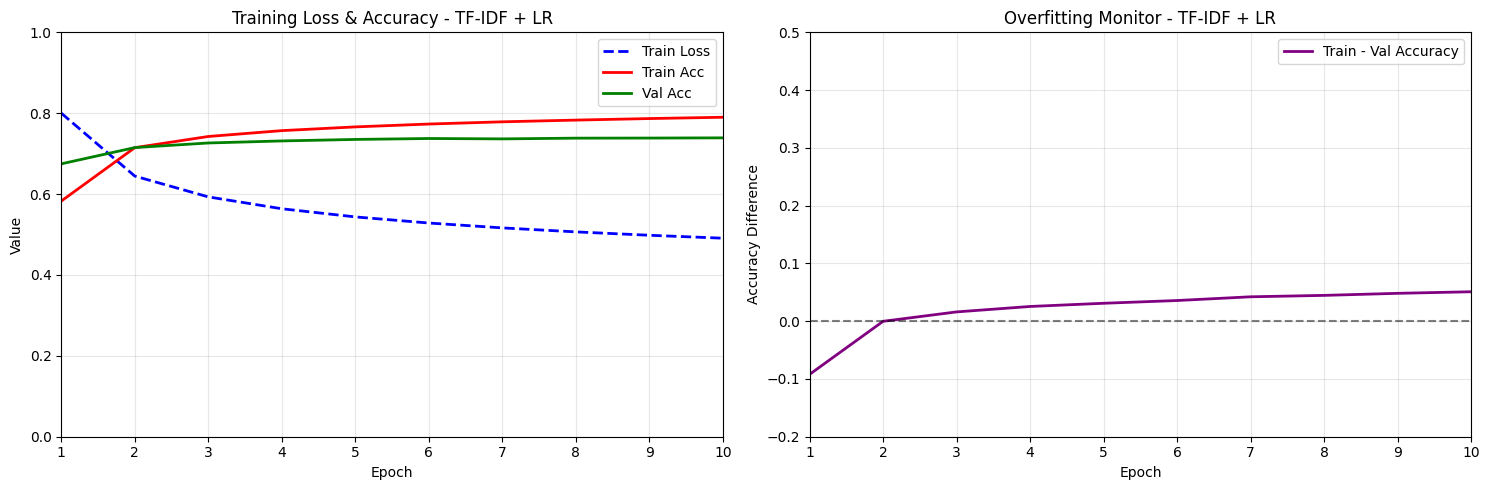


TRAINING SUMMARY
Model Name: TF-IDF + LR
Final Train Loss: 0.4909
Final Train Accuracy: 0.7900
Final Val Loss: 0.5817
Final Val Accuracy: 0.7391
Best Val Accuracy: 0.7391 (Epoch 10)
Final Overfitting Gap: 0.0509


In [10]:
# 绘制训练曲线
plot_training_curves("TF-IDF + LR", logreg_history)

# 打印训练摘要
print_training_summary("TF-IDF + LR", logreg_history)

最后，在测试集上评估模型性能，绘制混淆矩阵，并保存训练结果。

Testing: 100%|██████████| 58497/58497 [00:57<00:00, 1020.86it/s]



TEST RESULTS
Model Name: TF-IDF + LR
Test Accuracy: 0.7360
Test Precision (weighted): 0.7368
Test Recall (weighted): 0.7360
Test F1 Score (weighted): 0.7328

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8037    0.6956    0.7457     18605
     Neutral     0.6538    0.5882    0.6192     14749
    Positive     0.7359    0.8525    0.7900     25143

    accuracy                         0.7360     58497
   macro avg     0.7311    0.7121    0.7183     58497
weighted avg     0.7368    0.7360    0.7328     58497



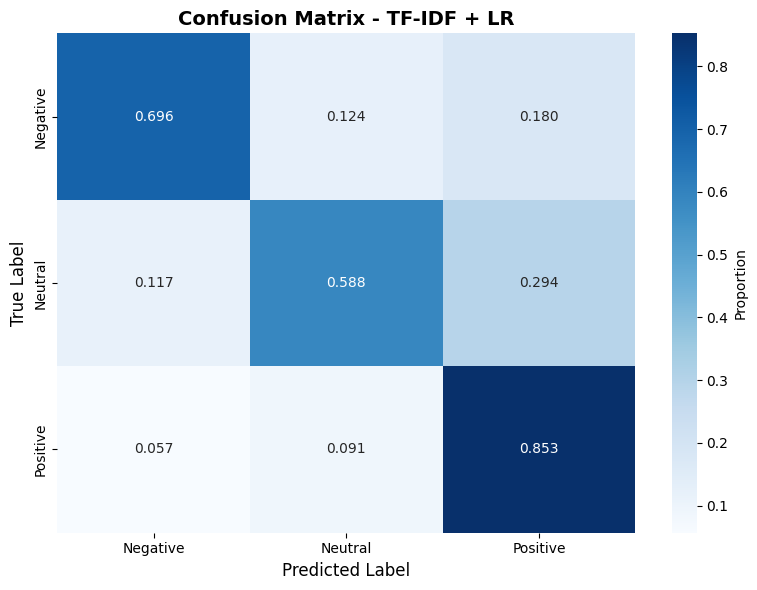


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8037, Recall=0.6956, F1=0.7457, Support=18605
 Neutral: Precision=0.6538, Recall=0.5882, F1=0.6192, Support=14749
Positive: Precision=0.7359, Recall=0.8525, F1=0.7900, Support=25143


In [ ]:
logreg_test_results = test_model_comprehensive(
    model=logreg,
    model_name="TF-IDF + LR",
    test_loader=test_data_loader_tfidf,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

In [12]:
save_training_results(
    model=logreg,
    model_name="TF-IDF + LR",
    set_epochs=num_epoch,
    actual_epochs=len(logreg_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=logreg_history,
    test_results=logreg_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: TF-IDF + LR (LogisticRegression)
  - 实际训练轮数: 10
  - 测试准确率: 0.7360
  - 测试F1分数: 0.7328
  - 记录时间: 2025-11-18 13:03:05
  - 总记录数: 31


#### 多层感知机

上一部分，我们使用多分类逻辑回归模型作为基线模型，取得了不错的效果。接下来，我们在逻辑回归模型的基础上更进一步，构建一个简单的多层感知机（Multi-Layer Perceptron, MLP）模型，并引入词袋（Bag-of-Words, BoW）模型。

##### 模型原理

回忆一下，多分类逻辑回归的网络模型中，只使用了一个线性层来进行特征变换，然后使用 Softmax 函数将线性输出转换为概率分布。

然而，在现实任务中，数据往往具有复杂的非线性关系，单一的线性变换可能无法充分捕捉这些关系。为此，我们通过在网络中增加待非线性激活函数的隐藏层，以增强模型的表达能力和学习复杂模式的能力，这就是多层感知机（Multi-layer Perceptron, MLP）模型的核心架构。

例如，我们可以设计如下的多层感知机：
$$
\bm{z} = \bm{W}^{[1]}\bm{x} + \bm{b}^{[1]}
$$
$$
\bm{h} = \text{ReLU}(\bm{z})
$$
$$
\bm{y} = \bm{W}^{[2]}\bm{h} + \bm{b}^{[2]}
$$
式中，$\bm{W}^{[i]}$ 和 $\bm{b}^{[i]}$ 分别表示第 $i$ 层感知机的权重和偏置项；$\text{ReLU}$（Rectified Linear Unit）是一种非线性激活函数，定义为：
$$
\text{ReLU}(x)=\max(0,z)
$$

值得注意的是，MLP 模型可以解决非线性可分问题，这是逻辑回归模型无法胜任的任务。



我们可以直接使用 PyTorch 框架中已实现的各种激活函数作为隐藏层的函数。

例如，我们将在下面 MLP 模型的实现代码中看到：
```python
from torch.nn import functional as F

class MLP(nn.Module):
    def __init__(self, ..., hidden_dim, ...):
        ...
        self.linear1 = nn.Linear(..., hidden_dim)
        self.activate = F.relu
        self.linear2 = nn.Linear(hidden_dim, ...)
    
    def forward(self, ...):
        ...
        hidden = self.activate(self.linear1(...))
        output = self.linear2(hidden)
        ...
```


##### 词嵌入表示
在上一部分中，我们使用了 TF-IDF 方法将文本转换为特征向量。

回忆一下，TF-IDF 采用基于词频统计的方法，为每个文档（即每个句子）生成高维、稀疏的特征向量。每个句子对应的特征向量是通过对语料库进行统计得到的，一旦确定，向量值就不会改变。

这种方式虽然简单有效、可解释性强，但往往无法捕捉词语之间的语义相似性，且高维、稀疏的特点可能导致模型训练效率低下。

为了解决上述问题，我们引入了词嵌入（Word Embedding，又称为词向量）表示方法，并结合词袋（Bag-of-Words, BoW）模型来表示文本。

词嵌入表示中，每个词语被映射到一个低维、稠密的向量空间中。不同于 TF-IDF 所生成的特征向量的向量值不变性，词嵌入表示可以通过训练不断调整词向量，使其更好地捕捉词语之间的语义关系，例如使得“开心”和“高兴”的词向量在向量空间中更接近。此时，我们可以将词向量中的向量值视作模型的参数，通过反向传播算法进行优化。

PyTorch 框架提供了 `nn.Embedding` 类来实现词向量表示。

当创建词向量对象时，需要提供两个参数：词表大小（`num_embeddings`）和词向量维度（`embedding_dim`）。

创建词向量对象后，PyTorch 会随机初始化词向量矩阵，矩阵的形状为 `(num_embeddings, embedding_dim)`。在训练过程中，词向量矩阵的值会根据任务的需要进行更新和优化。

例如：

In [4]:
import torch
from torch import nn

embedding = nn.Embedding(8, 3)  # 词表大小为8，词向量维度为3

inputs = torch.tensor([
    [0, 1, 2, 1], 
    [4, 6, 6, 7]
], dtype=torch.long)  # 输入形状为 (2, 4) 的整数向量，每个整数范围是 0~7

outputs = embedding(inputs)  

outputs

tensor([[[ 0.5103,  0.6973, -0.8252],
         [-1.0999,  0.1567,  1.0740],
         [ 1.1403, -0.4303,  0.1397],
         [-1.0999,  0.1567,  1.0740]],

        [[ 0.2547, -0.8688,  1.6823],
         [-1.6692, -0.9043,  1.2758],
         [-1.6692, -0.9043,  1.2758],
         [ 0.1298, -0.4576, -1.1726]]], grad_fn=<EmbeddingBackward0>)

如前所述，词向量层需要足够的训练数据来学习合适的词向量。不过，如果目标任务的训练数据较少，那么学习合适的词向量难度会比较大。因此，利用自然语言文本所蕴含的自监督学习信号（词与上下文的贡献关系），先预训练词向量，往往会获得更好的结果。

关于预训练词向量的内容，我们会在 `06Pre-trained Word Embeddings.ipynb` 中进行详细介绍，并在 `08Comparison and Analysis.ipynb` 中比较使用预训练词向量与随机初始化词向量的同种模型的性能差异。

##### 文本的词袋表示
根据多层感知机的实现方式我们知道，模型的输入需要是一个固定长度的向量。如果输入为文本数据，则需要将文本中的词语（更准确地，词元，关于词元化见 `04Segmentation and Tokenization.ipynb`）通过上述的词嵌入方式转换为向量表示。

但是，一个句子通常含有多个词元，如何将多个词元的词向量合并为一个固定长度的向量呢？

这里，我们使用词袋（Bag-of-Words, BoW）模型来实现这一目标。词袋模型的核心思想是：表示一个句子时，不考虑其中词元的顺序，仅将其简单地视为一个集合。于是就可以采用聚合操作处理一个句子中的所有词元的词向量，得到一个固定长度的向量表示。

In [ ]:
print(outputs)

emb_agg = outputs.mean(dim=1)  # 在序列长度维度上取平均

emb_agg

tensor([[[ 0.5103,  0.6973, -0.8252],
         [-1.0999,  0.1567,  1.0740],
         [ 1.1403, -0.4303,  0.1397],
         [-1.0999,  0.1567,  1.0740]],

        [[ 0.2547, -0.8688,  1.6823],
         [-1.6692, -0.9043,  1.2758],
         [-1.6692, -0.9043,  1.2758],
         [ 0.1298, -0.4576, -1.1726]]], grad_fn=<EmbeddingBackward0>)


tensor([[-0.1373,  0.1451,  0.3656],
        [-0.7385, -0.7837,  0.7653]], grad_fn=<MeanBackward1>)

然而，更实际的自然语言处理任务中，一个批次里输入的文本长度往往是不固定的，因此无法像上面的代码一样简单地用一个张量存储词向量并求平均值。

PyTorch 提供了一种更灵活的解决方案，即 EmbeddingBag 层。

在调用 EmbeddingBag 层时，首先需要将不定长的序列拼接起来，然后用一个偏移向量（`offsets`）记录每个序列的起始位置。EmbeddingBag 层会根据偏移向量自动将拼接后的序列划分为多个子序列，并对每个子序列的词向量进行聚合操作（如求和或求平均），从而得到每个句子的固定长度向量表示。例如：

In [9]:
input1 = torch.tensor([0, 1, 2, 1], dtype=torch.long)
input2 = torch.tensor([2, 1, 3, 7, 6], dtype=torch.long)
input3 = torch.tensor([6, 4, 2], dtype=torch.long)
input4 = torch.tensor([4, 6, 6, 7, 5, 2], dtype=torch.long)

inputs = [input1, input2, input3, input4]

offsets = [0] + [i.shape[0] for i in inputs]

print(f"offsets before cumsum: {offsets}")

offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

print(f"offsets after cumsum: {offsets}")

inputs = torch.cat(inputs)

print(f"inputs after cat: {inputs}")

embeddingbag = nn.EmbeddingBag(num_embeddings=8, embedding_dim=3)
embeddings = embeddingbag(inputs, offsets)  # 输出形状为 (4, 3)
print(embeddings)

offsets before cumsum: [0, 4, 5, 3, 6]
offsets after cumsum: tensor([ 0,  4,  9, 12])
inputs after cat: tensor([0, 1, 2, 1, 2, 1, 3, 7, 6, 6, 4, 2, 4, 6, 6, 7, 5, 2])
tensor([[ 0.0534,  0.3759, -0.7084],
        [ 0.8864, -0.4906, -1.2858],
        [ 0.7417, -0.6581, -0.0579],
        [ 1.0693, -0.6454, -0.5505]], grad_fn=<EmbeddingBagBackward0>)


##### 数据集与加载器构建

为了将数据转换为便于 PyTorch 使用的形式，我们同样需要定义数据适配器和数据加载器。

数据适配器 `BowDataset` 的定义是简单的，这是因为我们事先已经做好了文本的分词与向量化处理。适配器名称中的 `Bow` 是词袋的意思。

In [ ]:
from torch.utils.data import Dataset

class BowDataset(Dataset):  #@save
    def __init__(self, data: DataFrame) -> None:
        self.data = data

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, i: int):
        return self.data.iloc[i]
    

# 加载数据
train_dataset = BowDataset(train_tok)
val_dataset = BowDataset(val_tok)
test_dataset = BowDataset(test_tok)

构建数据加载器时，不同于逻辑回归，对于输入的每一个数据批次，我们需要按照上面提到的 `nn.EmbeddingBag` 的要求，构建拼接后的词元索引张量 `inputs` 和偏移向量 `offsets`。

这相当于对输入数据批次的形式进行整理，其逻辑可以定义成为一个整理函数，在数据加载器中作为 `collate_fn` 参数传入。

In [ ]:
from torch.utils.data import DataLoader

def collate_fn_mlp(batch):  #@save
    # 从独立样本集合中构建各批次的输入输出
    # 其中 BowDataset 类定义了一个样本的数据结构，即输入标签和输出标签的元组
    # 因此，将输入 inputs 定义为一个张量的列表，其中每个张量为原始句子中词元序列对应的索引值序列
    inputs = [torch.tensor(b["text"]) for b in batch]

    # 输出的目标 targets 为该批次中由全部样例输出结果构成的张量
    targets = torch.tensor([b["label"] for b in batch], dtype=torch.long)

    # 获取一个批次中每个样例的序列长度
    offsets = [0] + [i.shape[0] for i in inputs]

    # 根据序列的长度，转换为每个序列起始位置的偏移量
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # 将 inputs 列表中的张量拼接成一个大的张量
    inputs = torch.cat(inputs)

    return inputs, offsets, targets


train_data_loader_mlp = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=True)
val_data_loader_mlp = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=False)
test_data_loader_mlp = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_mlp, shuffle=False)

##### 模型构建

完成相关准备工作后，我们就可以开始搭建 MLP模型了。

MLP 的基本架构已在前面的部分提及，相对简单。

下面的代码中，构造方法的参数 `pretrained_embedding_matrix` 的作用是提供初始化词向量矩阵的预训练词向量，我们会在 `06Pre-train Word Embedding.ipynb` 中使用这个参数。在本 Notebook 中，我们不提供该参数，PyTorch 则使用随机初始化的词向量。

在神经网络架构方面，除已提及的词嵌入层、线性层和隐藏层外，我们还引入了 Dropout 层，以进一步防止模型过拟合。

Dropout 层通过在训练过程中随机“丢弃”一部分神经元，减少神经元之间的复杂共适应关系，从而提高模型的泛化能力。

In [14]:
from torch.nn import functional as F

class MLP(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class, 
                 pretrained_embedding_matrix=None, freeze=True):
        super(MLP, self).__init__()

        # EmbeddingBag 层
        if pretrained_embedding_matrix is not None:
            self.embeddingbag = nn.EmbeddingBag.from_pretrained(pretrained_embedding_matrix, freeze=freeze, mode="mean")
        else:
            self.embeddingbag = nn.EmbeddingBag(vocab_size, embedding_dim)


        # 线性变换：词向量层 -> 隐含层
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)

        # 使用ReLU激活函数
        self.activate = F.relu

        # 线性变换：激活层 -> 输出层
        self.linear2 = nn.Linear(hidden_dim, num_class)

        self.dropout = nn.Dropout(0.5)
    
    def forward(self, inputs, offsets):
        embedding = self.embeddingbag(inputs, offsets)
        hidden = self.activate(self.linear1(embedding))
        hidden = self.dropout(hidden)
        outputs = self.linear2(hidden)
        return outputs

##### 模型训练与测试

最后，我们可以开始训练 MLP 模型了。

在超参数设置上，我们将嵌入维度 `embedding_dim` 设为 `200`，这是为了与后续实验中使用的预训练词向量维度保持一致，便于比较。

In [ ]:
# 超参数设置
embedding_dim = 200
num_class = 3
hidden_dim = 256
batch_size = 32
num_epoch = 10

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp = MLP(len(vocab), embedding_dim, hidden_dim, num_class)
mlp.to(device)

weights = class_weights(train_tok)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

MLP(
  (embeddingbag): EmbeddingBag(35272, 200, mode='mean')
  (linear1): Linear(in_features=200, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
# 使用通用训练函数
mlp_history = train_model_with_validation(
    model=mlp,
    train_loader=train_data_loader_mlp,
    val_loader=val_data_loader_mlp,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device,
)

Training Epoch 1: 100%|██████████| 8532/8532 [00:40<00:00, 209.36it/s]


Epoch 1/10
    Train Loss: 0.7009	Train Accuracy: 0.6771
    Valid Loss: 0.6131	Valid Accuracy: 0.7293
    Valid Precision: 0.7282	Valid Recall: 0.7293	Valid F1: 0.7220
    ✓ New best validation loss: 0.6131
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [00:40<00:00, 211.17it/s]


Epoch 2/10
    Train Loss: 0.5774	Train Accuracy: 0.7477
    Valid Loss: 0.5912	Valid Accuracy: 0.7398
    Valid Precision: 0.7407	Valid Recall: 0.7398	Valid F1: 0.7335
    ✓ New best validation loss: 0.5912
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [00:40<00:00, 212.40it/s]


Epoch 3/10
    Train Loss: 0.5346	Train Accuracy: 0.7693
    Valid Loss: 0.5846	Valid Accuracy: 0.7446
    Valid Precision: 0.7438	Valid Recall: 0.7446	Valid F1: 0.7391
    ✓ New best validation loss: 0.5846
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [00:40<00:00, 212.52it/s]


Epoch 4/10
    Train Loss: 0.5062	Train Accuracy: 0.7824
    Valid Loss: 0.5897	Valid Accuracy: 0.7503
    Valid Precision: 0.7484	Valid Recall: 0.7503	Valid F1: 0.7478
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [00:40<00:00, 212.13it/s]


Epoch 5/10
    Train Loss: 0.4837	Train Accuracy: 0.7934
    Valid Loss: 0.5980	Valid Accuracy: 0.7463
    Valid Precision: 0.7461	Valid Recall: 0.7463	Valid F1: 0.7404
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8532/8532 [00:40<00:00, 212.00it/s]


Epoch 6/10
    Train Loss: 0.4636	Train Accuracy: 0.8031
    Valid Loss: 0.6082	Valid Accuracy: 0.7460
    Valid Precision: 0.7471	Valid Recall: 0.7460	Valid F1: 0.7420
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5846


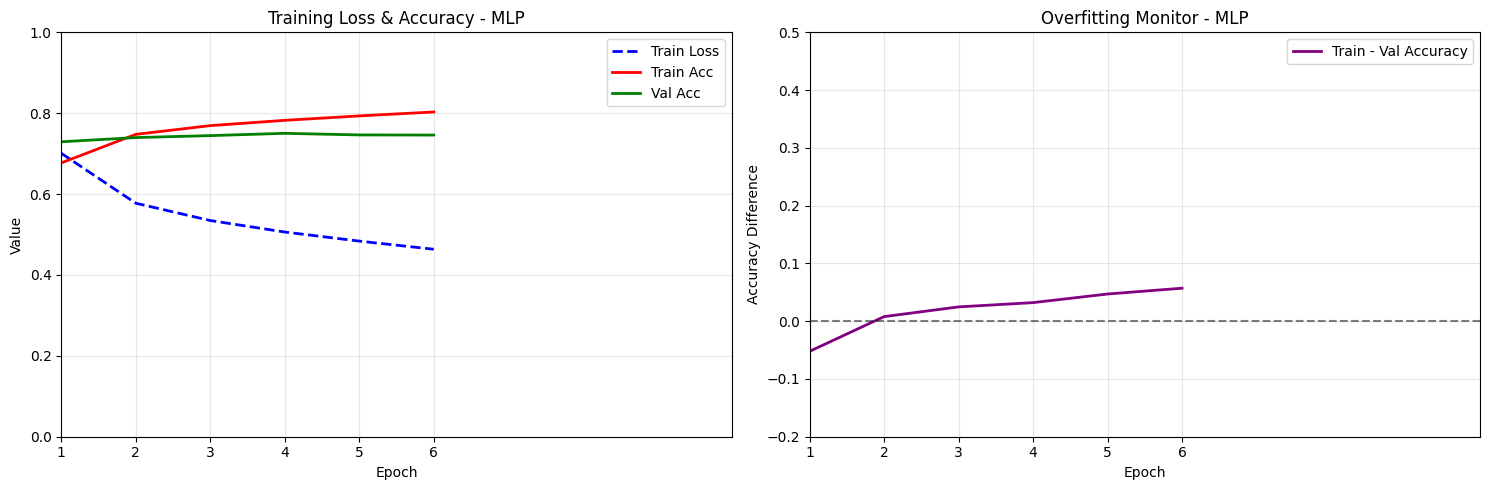


TRAINING SUMMARY
Model Name: MLP
Final Train Loss: 0.4636
Final Train Accuracy: 0.8031
Final Val Loss: 0.6082
Final Val Accuracy: 0.7460
Best Val Accuracy: 0.7503 (Epoch 4)
Final Overfitting Gap: 0.0571


In [17]:
# 绘制训练曲线
plot_training_curves("MLP", mlp_history)

# 打印训练摘要
print_training_summary("MLP", mlp_history)

Testing: 100%|██████████| 58497/58497 [00:45<00:00, 1293.53it/s]



TEST RESULTS
Model Name: MLP
Test Accuracy: 0.7426
Test Precision (weighted): 0.7412
Test Recall (weighted): 0.7426
Test F1 Score (weighted): 0.7370

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7829    0.7425    0.7622     18605
     Neutral     0.6986    0.5396    0.6089     14749
    Positive     0.7354    0.8617    0.7935     25143

    accuracy                         0.7426     58497
   macro avg     0.7390    0.7146    0.7215     58497
weighted avg     0.7412    0.7426    0.7370     58497



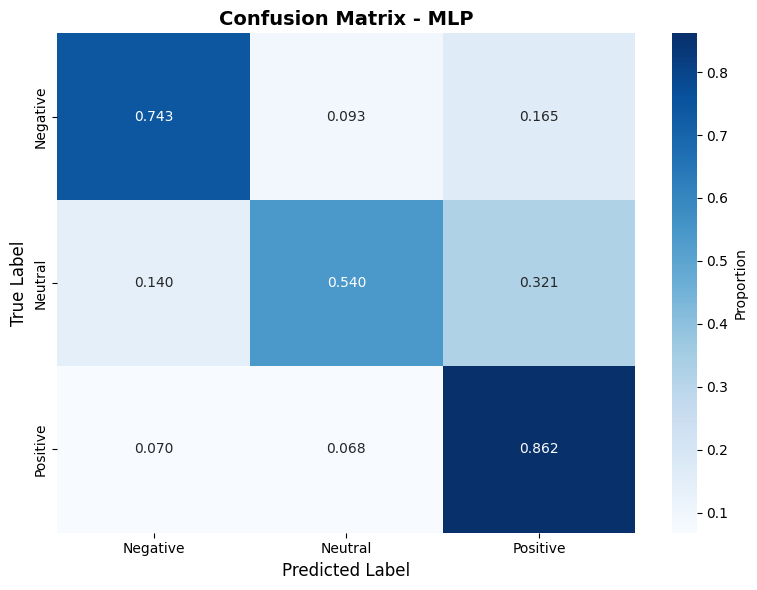


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7829, Recall=0.7425, F1=0.7622, Support=18605
 Neutral: Precision=0.6986, Recall=0.5396, F1=0.6089, Support=14749
Positive: Precision=0.7354, Recall=0.8617, F1=0.7935, Support=25143


In [18]:
# MLP 测试过程 - 使用通用框架
mlp_test_results = test_model_comprehensive(
    model=mlp,
    model_name="MLP",
    test_loader=test_data_loader_mlp,
    device=device,
)

In [19]:
# 保存MLP训练结果
save_training_results(
    model=mlp,
    model_name="MLP",
    set_epochs=num_epoch,
    actual_epochs=len(mlp_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=mlp_history,
    test_results=mlp_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: MLP (MLP)
  - 实际训练轮数: 6
  - 测试准确率: 0.7426
  - 测试F1分数: 0.7370
  - 记录时间: 2025-11-18 13:08:10
  - 总记录数: 32


### 卷积神经网络

俗话说：“卷卷卷，天天就知道卷，你卷泥马呢。”

在深度学习领域，“卷”也是一种非常重要的操作，最有代表性的模型就是卷积神经网络（Convolutional Neural Network, CNN）。

在上面实现的 MLP 模型中，每层输入的各元素需要乘以一个独立的权重。然而，对于文本情感分类任务，这样做可能并不合适，因为句子的情感极性往往由个别词或短语决定，而这些决定性的词或短语在句子中的位置并不固定，若仅使用全连接层（或称为稠密层），模型难以捕捉到这些局部特征。

为了解决以上问题，一个非常直接的想法是使用一个小的稠密层，在句子中滑动，以捕捉局部特征。该操作又被称为卷积（Convolution）操作，其中每个小的、用于提取局部特征的稠密层又被称为卷积核（Convolution Kernel）或滤波器（Filter）。

卷积操作输出的结果还可以进一步聚合，这一过程称为池化（Pooling）操作。常用的池化操作有最大池化、平均池化等。

以最大池化为例，其含义是仅保留最有意义的局部特征。如在情感分类任务中，保留的是句子中对于分类最关键的 N-gram 信息。

在进行卷积操作时，还可以使用多个卷积核提取不同种类的局部特征。

卷积核的构造方式大致有两种，一种是使用不同组的参数，并使用不同的初始化参数，获得不同的卷积核；另一种是提取不同尺度的局部特征，如提取不同大小的 N-gram。

多个卷积核会输出多个特征，为了衡量各个特征对最终分类结果的贡献，只需要再经过一个全连接的分类层就可以做出最终的决策。

最后，还可以将多个卷积层加池化层堆叠起来，形成更深层的网络，这些网络统称为卷积神经网络（Convolutional Neural Network, CNN）。

上面针对文本等序列数据的卷积操作只沿单一方向滑动，称为一维卷积。而对于图像等数据，则需要在二维空间内滑动，称为二维卷积。类似的还有三维卷积。

实际上，卷积神经网络最初是为图像处理任务设计的，后来才被广泛应用于各种任务中，包括文本分类任务。由于二维及以上的卷积操作在自然语言处理中并不常用，因此在这里不做过多介绍。

PyTorch 中提供了 `nn.Conv1d` 类来实现一维卷积操作，其构造函数至少需要提供三个参数：`in_channels` 为输入通道的个数，在输入层对应词向量的维度；`out_channels` 为输出通道的个数，对应卷积核的个数；`kernel_size` 为每个卷积核的宽度

当调用该 `Conv1d` 对象时，输入数据形状为 `(batch, in_channels, seq_len)`，输出数据形状为 `(batch, out_channels, seq_len)`，其中在输入数据和输出数据中，`seq_len` 分别表示输入序列和输出序列的长度。

In [13]:
import torch
from torch.nn import Conv1d

# 定义一个一维卷积，输入通道大小为5，输出通道大小为2，卷积核宽度为4
conv1 = Conv1d(5, 2, 4)

# 再定义一个一维卷积，输入通道大小为5，输出通道大小为2，卷积核宽度为3
conv2 = Conv1d(5, 2, 3)

# 输入数据批次大小为2，即有两个序列，每个序列的长度为6，每个输入的维度为5
inputs = torch.rand(2, 5, 6)

# 通过第一个卷积层
outputs1 = conv1(inputs)

# 通过第二个卷积层
outputs2 = conv2(inputs)

print(f"outputs1: \n{outputs1}")
print(f"outputs2: \n{outputs2}")

outputs1: 
tensor([[[-0.0246, -0.2645, -0.1231],
         [ 0.2167,  0.2505,  0.5243]],

        [[ 0.2451, -0.4906, -0.2208],
         [ 0.3399,  0.2482,  0.4360]]], grad_fn=<ConvolutionBackward0>)
outputs2: 
tensor([[[ 0.3099, -0.0095,  0.2644,  0.3341],
         [ 0.6221,  0.4088,  0.2807,  0.5533]],

        [[ 0.3722,  0.1205,  0.0256, -0.1621],
         [ 0.4075,  0.3372,  0.5520,  0.5944]]],
       grad_fn=<ConvolutionBackward0>)


接下来需要调用池化层类。`torch.nn` 模块中提供了多种池化层的实现，例如 `nn.MaxPool1d` 实现了一维最大池化操作，其构造函数至少需要提供一个参数 `kernel_size`，表示池化窗口的大小，也就是对多大范围内的输入进行聚合。如果对整个输入序列进行池化操作，则其大小应为卷积层输出的序列长度。

In [14]:
from torch.nn import MaxPool1d

pool1 = MaxPool1d(3)  # 池化核宽度为3，即卷积层的输出序列长度
pool2 = MaxPool1d(4)  # 池化核宽度为4

outputs_pool1 = pool1(outputs1)  # 执行一维最大池化操作，即取每行输入的最大值
output2_pool2 = pool2(outputs2)

print(f"outputs_pool1: \n{outputs_pool1}")
print(f"output2_pool2: \n{output2_pool2}")

outputs_pool1: 
tensor([[[-0.0246],
         [ 0.5243]],

        [[ 0.2451],
         [ 0.4360]]], grad_fn=<SqueezeBackward1>)
output2_pool2: 
tensor([[[0.3341],
         [0.6221]],

        [[0.3722],
         [0.5944]]], grad_fn=<SqueezeBackward1>)


除了使用池化层对象实现池化，PyTorch 还在 `torch.nn.functional` 中实现了池化函数，如 `max_pool1d` 等，即无需定义一个池化层对象就可以直接调用池化功能。

这两种实现方法基本一致，一个显著的区别在于使用池化函数时无须实现指定池化层核的大小，只要在调用时提供即可。

当处理不定长度的序列时，这种实现方法更加适合。

In [15]:
import torch.nn.functional as F

outputs_pool1 = F.max_pool1d(outputs1, kernel_size=outputs1.shape[2])  # 池化核宽度等于序列长度
output2_pool2 = F.max_pool1d(outputs2, kernel_size=outputs2.shape[2])

print(f"outputs_pool1: \n{outputs_pool1}")
print(f"output2_pool2: \n{output2_pool2}")

outputs_pool1: 
tensor([[[-0.0246],
         [ 0.5243]],

        [[ 0.2451],
         [ 0.4360]]], grad_fn=<SqueezeBackward1>)
output2_pool2: 
tensor([[[0.3341],
         [0.6221]],

        [[0.3722],
         [0.5944]]], grad_fn=<SqueezeBackward1>)


由于 `outputs_pool1` 和 `outputs_pool2` 是两个独立的张量，为了执行下一步操作，还需要调用 `torch.cat` 函数将它们拼接起来。

在此之前，还需要调用 `squeeze` 函数，将最后一个为 $1$ 的维度删除，即将 $2$ 行 $1$ 列的张量转换为 1 个向量。

In [16]:
outputs_pool_squeeze1 = outputs_pool1.squeeze(dim=2)
output2_pool_squeeze2 = output2_pool2.squeeze(dim=2)

print(f"outputs_pool_squeeze1: \n{outputs_pool_squeeze1}")
print(f"output2_pool_squeeze2: \n{output2_pool_squeeze2}")

outputs_pool = torch.cat([outputs_pool_squeeze1, output2_pool_squeeze2], dim=1)  # 在特征维度上拼接

print(f"outputs_pool: \n{outputs_pool}")

outputs_pool_squeeze1: 
tensor([[-0.0246,  0.5243],
        [ 0.2451,  0.4360]], grad_fn=<SqueezeBackward1>)
output2_pool_squeeze2: 
tensor([[0.3341, 0.6221],
        [0.3722, 0.5944]], grad_fn=<SqueezeBackward1>)
outputs_pool: 
tensor([[-0.0246,  0.5243,  0.3341,  0.6221],
        [ 0.2451,  0.4360,  0.3722,  0.5944]], grad_fn=<CatBackward0>)


最后再连接一个全连接层，实现分类功能。

In [17]:
from torch.nn import Linear

linear = Linear(4, 2)
outputs_linear = linear(outputs_pool)
print(f"outputs_linear: \n{outputs_linear}")

outputs_linear: 
tensor([[0.6160, 0.9216],
        [0.4917, 0.9752]], grad_fn=<AddmmBackward0>)


##### 模型搭建

CNN 模型的搭建与 MLP 是类似的，区别主要在于添加了卷积层和池化层。

此外，在调用 CNN 时，还需要设置两个额外的超参数，分别为 `filter_size` 表示卷积核的大小，以及 `num_filters` 表示卷积核的个数。

In [20]:
class CNN(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, filter_size, num_filter, num_class,
                 pretrained_embedding_matrix=None, freeze=True) -> None:
        super(CNN, self).__init__()
        if pretrained_embedding_matrix:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=freeze)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(embedding_dim, num_filter, filter_size, padding=1)  # padding=1 表示在卷积操作之前，将序列的前后各补充1个输入
        self.dropout = nn.Dropout(0.5)
        self.activate = F.relu
        self.linear = nn.Linear(num_filter, num_class)

    
    def forward(self, inputs):
        embedding = self.embedding(inputs)
        convolution = self.activate(self.conv1d(embedding.permute(0, 2, 1)))
        convolution = self.dropout(convolution)
        pooling = F.max_pool1d(convolution, kernel_size=convolution.shape[2])
        outputs = self.linear(pooling.squeeze(dim=2))
        return outputs

另外，也需要对数据整理函数进行一些修改。

代码中，`pad_sequence` 函数实现补齐（Padding）功能，使一个批次中全部序列长度相同，同最大长度序列，不足的默认用 `0` 补齐。

In [21]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_cnn(batch):
    inputs = [torch.tensor(b["text"]) for b in batch]
    targets = torch.tensor([b["label"] for b in batch], dtype=torch.long)

    # 对批次内的样本补齐，使其具有相同的长度
    inputs = pad_sequence(inputs, batch_first=True)
    return inputs, targets

In [22]:
train_data_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=True)
test_data_loader_cnn = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_cnn, shuffle=False)

# CNN 相关参数
filter_size = 3
num_filter = 100

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = CNN(len(vocab), embedding_dim, filter_size, num_filter, num_class)
cnn.to(device)

CNN(
  (embedding): Embedding(35272, 200)
  (conv1d): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [23]:
# CNN 训练过程 - 使用通用框架
weights = class_weights(train_tok)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_cnn = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=False)

# 使用通用训练函数
cnn_history = train_model_with_validation(
    model=cnn,
    train_loader=train_data_loader_cnn,
    val_loader=val_data_loader_cnn,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 8532/8532 [00:42<00:00, 200.04it/s]


Epoch 1/10
    Train Loss: 0.7128	Train Accuracy: 0.6665
    Valid Loss: 0.6849	Valid Accuracy: 0.6984
    Valid Precision: 0.7337	Valid Recall: 0.6984	Valid F1: 0.7030
    ✓ New best validation loss: 0.6849
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [00:41<00:00, 204.84it/s]


Epoch 2/10
    Train Loss: 0.5928	Train Accuracy: 0.7384
    Valid Loss: 0.6240	Valid Accuracy: 0.7027
    Valid Precision: 0.7308	Valid Recall: 0.7027	Valid F1: 0.6937
    ✓ New best validation loss: 0.6240
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [00:41<00:00, 205.02it/s]


Epoch 3/10
    Train Loss: 0.5484	Train Accuracy: 0.7629
    Valid Loss: 0.5933	Valid Accuracy: 0.7454
    Valid Precision: 0.7488	Valid Recall: 0.7454	Valid F1: 0.7443
    ✓ New best validation loss: 0.5933
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [00:42<00:00, 202.99it/s]


Epoch 4/10
    Train Loss: 0.5187	Train Accuracy: 0.7772
    Valid Loss: 0.5924	Valid Accuracy: 0.7522
    Valid Precision: 0.7494	Valid Recall: 0.7522	Valid F1: 0.7499
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [00:41<00:00, 203.74it/s]


Epoch 5/10
    Train Loss: 0.4968	Train Accuracy: 0.7883
    Valid Loss: 0.5814	Valid Accuracy: 0.7374
    Valid Precision: 0.7464	Valid Recall: 0.7374	Valid F1: 0.7326
    ✓ New best validation loss: 0.5814
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8532/8532 [00:42<00:00, 201.48it/s]


Epoch 6/10
    Train Loss: 0.4752	Train Accuracy: 0.7986
    Valid Loss: 0.5896	Valid Accuracy: 0.7412
    Valid Precision: 0.7515	Valid Recall: 0.7412	Valid F1: 0.7434
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 8532/8532 [00:42<00:00, 200.54it/s]


Epoch 7/10
    Train Loss: 0.4563	Train Accuracy: 0.8086
    Valid Loss: 0.5853	Valid Accuracy: 0.7432
    Valid Precision: 0.7505	Valid Recall: 0.7432	Valid F1: 0.7432
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 8532/8532 [00:42<00:00, 202.38it/s]


Epoch 8/10
    Train Loss: 0.4368	Train Accuracy: 0.8167
    Valid Loss: 0.6006	Valid Accuracy: 0.7331
    Valid Precision: 0.7467	Valid Recall: 0.7331	Valid F1: 0.7318
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5814


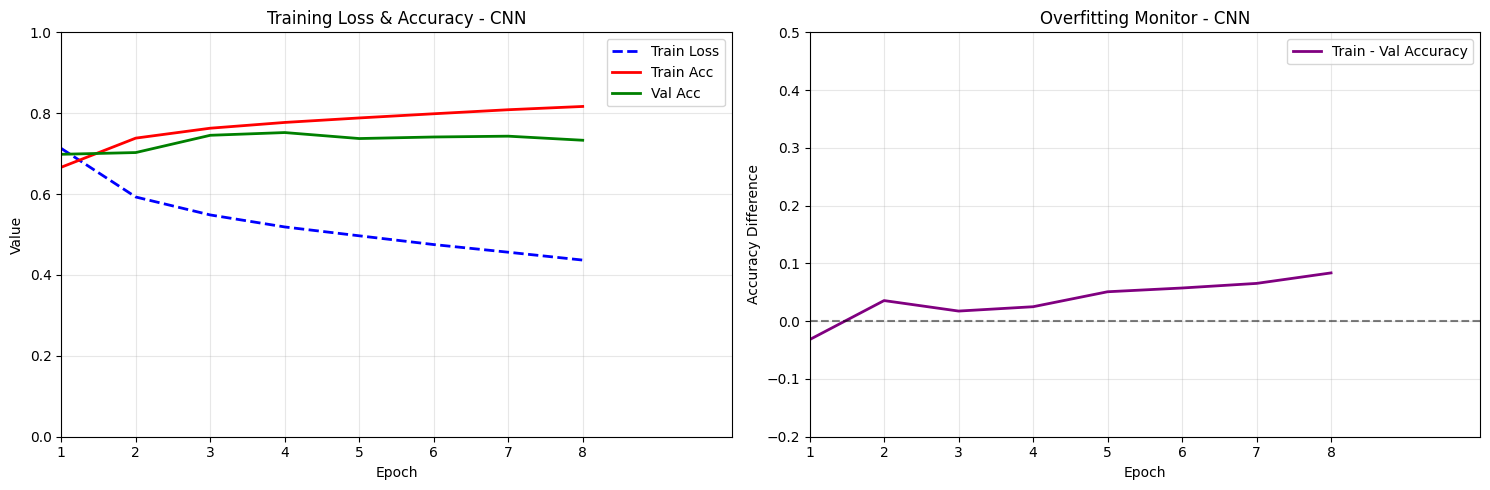


TRAINING SUMMARY
Model Name: CNN
Final Train Loss: 0.4368
Final Train Accuracy: 0.8167
Final Val Loss: 0.6006
Final Val Accuracy: 0.7331
Best Val Accuracy: 0.7522 (Epoch 4)
Final Overfitting Gap: 0.0836


In [24]:
# 绘制训练曲线
plot_training_curves("CNN", cnn_history)

# 打印训练摘要
print_training_summary("CNN", cnn_history)

Testing: 100%|██████████| 58497/58497 [00:59<00:00, 984.65it/s]



TEST RESULTS
Model Name: CNN
Test Accuracy: 0.7336
Test Precision (weighted): 0.7396
Test Recall (weighted): 0.7336
Test F1 Score (weighted): 0.7287

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8334    0.6672    0.7411     18605
     Neutral     0.6682    0.5656    0.6126     14749
    Positive     0.7121    0.8813    0.7877     25143

    accuracy                         0.7336     58497
   macro avg     0.7379    0.7047    0.7138     58497
weighted avg     0.7396    0.7336    0.7287     58497



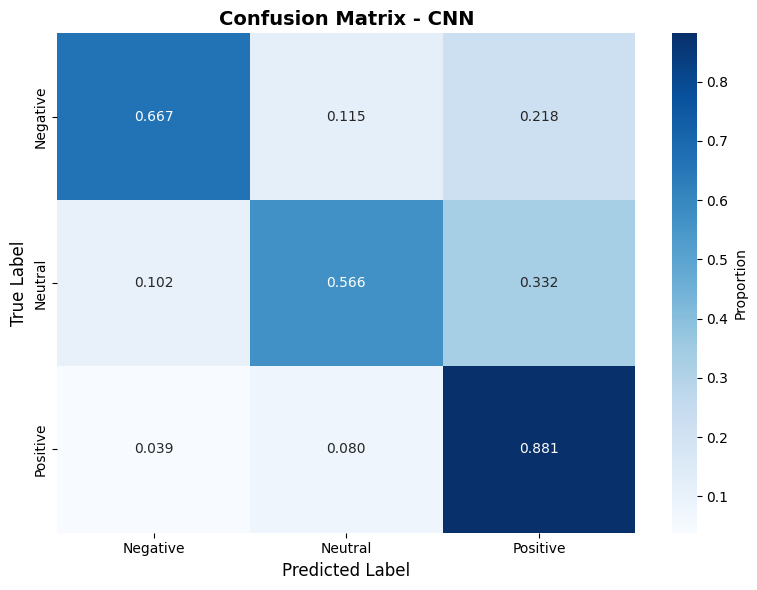


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8334, Recall=0.6672, F1=0.7411, Support=18605
 Neutral: Precision=0.6682, Recall=0.5656, F1=0.6126, Support=14749
Positive: Precision=0.7121, Recall=0.8813, F1=0.7877, Support=25143


In [25]:
# CNN 测试过程 - 使用通用框架
cnn_test_results = test_model_comprehensive(
    model=cnn,
    model_name="CNN",
    test_loader=test_data_loader_cnn,
    device=device
)

In [26]:
# 保存CNN训练结果
save_training_results(
    model=cnn,
    model_name="CNN",
    set_epochs=num_epoch,
    actual_epochs=len(cnn_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=cnn_history,
    test_results=cnn_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: CNN (CNN)
  - 实际训练轮数: 8
  - 测试准确率: 0.7336
  - 测试F1分数: 0.7287
  - 记录时间: 2025-11-18 13:15:16
  - 总记录数: 33


### 长短时记忆网络

In [27]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_lstm(batch):  #@save
    lengths = torch.tensor([len(b["text"]) for b in batch], dtype=torch.long)
    inputs = [torch.tensor(b["text"]) for b in batch]
    targets = torch.tensor([b["label"] for b in batch], dtype=torch.long)

    # 使用 pad_sequence 函数对输入序列进行填充
    inputs = pad_sequence(inputs, batch_first=True)

    return inputs, lengths, targets

In [28]:
from torch.nn.utils.rnn import pack_padded_sequence

class LSTM(nn.Module):  #@save
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_class, 
                 pretrained_embedding_matrix=None, freeze=True):
        super(LSTM, self).__init__()
        if pretrained_embedding_matrix:
            self.embeddings = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=freeze)
        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=0.3, num_layers=2)

        self.dropout = nn.Dropout(0.5)
        
        self.output = nn.Linear(hidden_dim, num_class)

    def forward(self, inputs, lengths):
        embedding = self.embeddings(inputs)

        # 使用 pack_padded_sequence 函数对嵌入序列进行打包
        x_pack = pack_padded_sequence(embedding, lengths, batch_first=True, enforce_sorted=False)
        hidden, (hn, cn) = self.lstm(x_pack)
        output = self.dropout(hn[-1])
        output = self.output(output)
        return output

In [29]:
train_data_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=True)
test_data_loader_lstm = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_lstm, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm = LSTM(len(vocab), embedding_dim, hidden_dim, num_class)
lstm.to(device)

LSTM(
  (embeddings): Embedding(35272, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [30]:
# LSTM 训练过程 - 使用通用框架
weights = class_weights(train_tok)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=False)

# 使用通用训练函数
lstm_history = train_model_with_validation(
    model=lstm,
    train_loader=train_data_loader_lstm,
    val_loader=val_data_loader_lstm,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 8532/8532 [01:16<00:00, 110.89it/s]


Epoch 1/10
    Train Loss: 0.6557	Train Accuracy: 0.6984
    Valid Loss: 0.5750	Valid Accuracy: 0.7488
    Valid Precision: 0.7487	Valid Recall: 0.7488	Valid F1: 0.7470
    ✓ New best validation loss: 0.5750
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [01:16<00:00, 111.49it/s]


Epoch 2/10
    Train Loss: 0.5124	Train Accuracy: 0.7782
    Valid Loss: 0.5454	Valid Accuracy: 0.7578
    Valid Precision: 0.7588	Valid Recall: 0.7578	Valid F1: 0.7539
    ✓ New best validation loss: 0.5454
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [01:16<00:00, 111.62it/s]


Epoch 3/10
    Train Loss: 0.4298	Train Accuracy: 0.8157
    Valid Loss: 0.5495	Valid Accuracy: 0.7643
    Valid Precision: 0.7628	Valid Recall: 0.7643	Valid F1: 0.7624
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [01:16<00:00, 111.85it/s]


Epoch 4/10
    Train Loss: 0.3574	Train Accuracy: 0.8493
    Valid Loss: 0.5779	Valid Accuracy: 0.7629
    Valid Precision: 0.7624	Valid Recall: 0.7629	Valid F1: 0.7615
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [01:16<00:00, 111.80it/s]


Epoch 5/10
    Train Loss: 0.2963	Train Accuracy: 0.8763
    Valid Loss: 0.6529	Valid Accuracy: 0.7635
    Valid Precision: 0.7627	Valid Recall: 0.7635	Valid F1: 0.7628
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5454


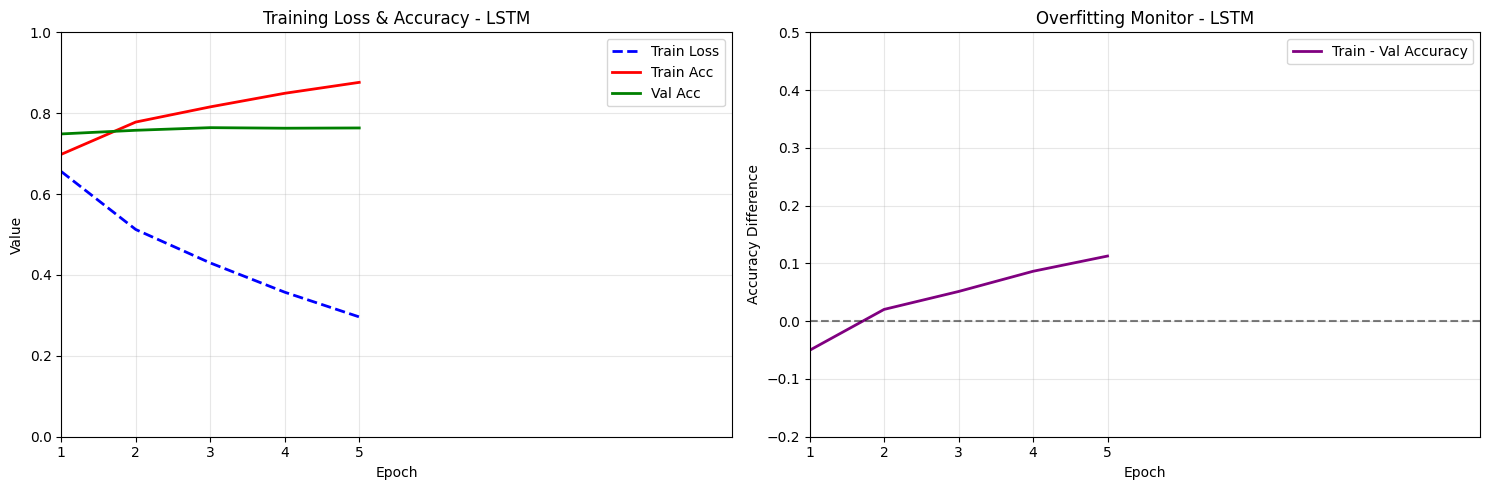


TRAINING SUMMARY
Model Name: LSTM
Final Train Loss: 0.2963
Final Train Accuracy: 0.8763
Final Val Loss: 0.6529
Final Val Accuracy: 0.7635
Best Val Accuracy: 0.7643 (Epoch 3)
Final Overfitting Gap: 0.1128


In [31]:
# 绘制训练曲线
plot_training_curves("LSTM", lstm_history)

# 打印训练摘要
print_training_summary("LSTM", lstm_history)

Testing: 100%|██████████| 58497/58497 [01:35<00:00, 615.06it/s]



TEST RESULTS
Model Name: LSTM
Test Accuracy: 0.7540
Test Precision (weighted): 0.7546
Test Recall (weighted): 0.7540
Test F1 Score (weighted): 0.7501

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8254    0.7285    0.7739     18605
     Neutral     0.6811    0.5806    0.6269     14749
    Positive     0.7453    0.8745    0.8048     25143

    accuracy                         0.7540     58497
   macro avg     0.7506    0.7279    0.7352     58497
weighted avg     0.7546    0.7540    0.7501     58497



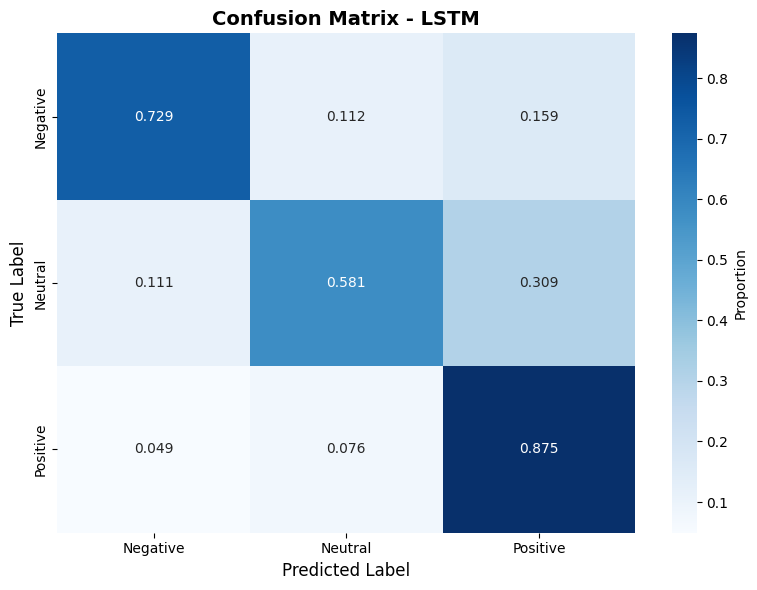


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8254, Recall=0.7285, F1=0.7739, Support=18605
 Neutral: Precision=0.6811, Recall=0.5806, F1=0.6269, Support=14749
Positive: Precision=0.7453, Recall=0.8745, F1=0.8048, Support=25143


In [32]:
# LSTM 测试过程 - 使用通用框架
lstm_test_results = test_model_comprehensive(
    model=lstm,
    model_name="LSTM", 
    test_loader=test_data_loader_lstm,
    device=device
)

In [33]:
# 保存LSTM训练结果
save_training_results(
    model=lstm,
    model_name="LSTM",
    set_epochs=num_epoch,
    actual_epochs=len(lstm_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=lstm_history,
    test_results=lstm_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: LSTM (LSTM)
  - 实际训练轮数: 5
  - 测试准确率: 0.7540
  - 测试F1分数: 0.7501
  - 记录时间: 2025-11-18 13:23:44
  - 总记录数: 34


### Transformer

In [34]:
import math

def length_to_mask(lengths):  #@save
    max_len = torch.max(lengths)
    mask = torch.arange(max_len, device=lengths.device).expand(lengths.shape[0], max_len) < lengths.unsqueeze(1)
    return mask

class PositionalEncoding(nn.Module):  #@save
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)) / d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        self.max_len = max_len

    def forward(self, x):
        # 如果输入序列长度超过预计算的位置编码长度，动态扩展位置编码
        seq_len = x.size(0)
        if seq_len > self.max_len:
            # 动态生成更长的位置编码
            pe_extended = torch.zeros(seq_len, self.d_model, device=x.device)
            position = torch.arange(0, seq_len, dtype=torch.float, device=x.device).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, self.d_model, 2, dtype=torch.float, device=x.device) * 
                                (-math.log(10000.0)) / self.d_model)
            pe_extended[:, 0::2] = torch.sin(position * div_term)
            pe_extended[:, 1::2] = torch.cos(position * div_term)
            pe_extended = pe_extended.unsqueeze(0).transpose(0, 1)
            x = x + pe_extended[:seq_len, :]
        else:
            x = x + self.pe[:seq_len, :]
        
        return self.dropout(x)

In [35]:
class Transformer(nn.Module):  #@save
    def __init__(
            self, 
            vocab_size, 
            embedding_dim, 
            num_class, 
            dim_feedforward=512, 
            num_head=2, 
            num_layers=2, 
            dropout=0.1, 
            max_len=512, 
            activation: str = "relu", 
            pretrained_embedding_matrix=None, 
            freeze=True
            ):
        super(Transformer, self).__init__()
        self.embedding_dim = embedding_dim
        if pretrained_embedding_matrix:
            self.embeddings = nn.Embedding.from_pretrained(pretrained_embedding_matrix, freeze=freeze)
        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = PositionalEncoding(embedding_dim, dropout, max_len)  # 位置编码

        encoder_layer = nn.TransformerEncoderLayer(embedding_dim, num_head, dim_feedforward, dropout, activation)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)

        self.output = nn.Linear(embedding_dim, num_class)

    def forward(self, inputs, lengths):
        inputs = torch.transpose(inputs, 0, 1)

        hidden_states = self.embeddings(inputs)
        hidden_states = self.position_embedding(hidden_states)

        lengths = lengths.to(inputs.device)
        attention_mask = length_to_mask(lengths) == False

        # 根据批次中每个序列长度生成 Mask 矩阵
        hidden_states = self.transformer(hidden_states, src_key_padding_mask=attention_mask)
        hidden_states = hidden_states[0, :, :]

        # 取第一个词元的输出结果作为分类层的输入
        outputs = self.output(hidden_states)
        return outputs

In [36]:
collate_fn_trans = collate_fn_lstm  #@save

In [37]:
train_data_loader_trans = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=True)
test_data_loader_trans = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_trans, shuffle=False)

# 加载模型（使用修复后的Transformer类）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer = Transformer(len(vocab), embedding_dim, num_class, max_len=512)  # 明确指定max_len=512
transformer.to(device)

e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer(
  (embeddings): Embedding(35272, 200)
  (position_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=200, out_features=3, bias=True)
)

In [38]:
# Transformer 训练过程 - 使用通用框架
weights = class_weights(train_tok)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

# 创建验证数据加载器
val_data_loader_trans = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=False)

# 使用通用训练函数
transformer_history = train_model_with_validation(
    model=transformer,
    train_loader=train_data_loader_trans,
    val_loader=val_data_loader_trans,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 8532/8532 [01:19<00:00, 107.98it/s]


Epoch 1/10
    Train Loss: 0.8579	Train Accuracy: 0.5683
    Valid Loss: 0.7935	Valid Accuracy: 0.6107
    Valid Precision: 0.6201	Valid Recall: 0.6107	Valid F1: 0.5998
    ✓ New best validation loss: 0.7935
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [01:18<00:00, 108.33it/s]


Epoch 2/10
    Train Loss: 0.8031	Train Accuracy: 0.6139
    Valid Loss: 0.7875	Valid Accuracy: 0.6168
    Valid Precision: 0.6188	Valid Recall: 0.6168	Valid F1: 0.6038
    ✓ New best validation loss: 0.7875
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [01:16<00:00, 112.00it/s]


Epoch 3/10
    Train Loss: 0.7780	Train Accuracy: 0.6325
    Valid Loss: 0.7500	Valid Accuracy: 0.6552
    Valid Precision: 0.6514	Valid Recall: 0.6552	Valid F1: 0.6505
    ✓ New best validation loss: 0.7500
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [01:05<00:00, 129.87it/s]


Epoch 4/10
    Train Loss: 0.7554	Train Accuracy: 0.6508
    Valid Loss: 0.7475	Valid Accuracy: 0.6517
    Valid Precision: 0.6520	Valid Recall: 0.6517	Valid F1: 0.6472
    ✓ New best validation loss: 0.7475
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [01:01<00:00, 137.85it/s]


Epoch 5/10
    Train Loss: 0.7278	Train Accuracy: 0.6694
    Valid Loss: 0.7221	Valid Accuracy: 0.6738
    Valid Precision: 0.6702	Valid Recall: 0.6738	Valid F1: 0.6697
    ✓ New best validation loss: 0.7221
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8532/8532 [01:01<00:00, 138.23it/s]


Epoch 6/10
    Train Loss: 0.7074	Train Accuracy: 0.6794
    Valid Loss: 0.7122	Valid Accuracy: 0.6839
    Valid Precision: 0.6800	Valid Recall: 0.6839	Valid F1: 0.6809
    ✓ New best validation loss: 0.7122
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 8532/8532 [01:01<00:00, 137.78it/s]


Epoch 7/10
    Train Loss: 0.6866	Train Accuracy: 0.6920
    Valid Loss: 0.7060	Valid Accuracy: 0.6778
    Valid Precision: 0.6778	Valid Recall: 0.6778	Valid F1: 0.6740
    ✓ New best validation loss: 0.7060
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 8532/8532 [01:01<00:00, 137.95it/s]


Epoch 8/10
    Train Loss: 0.6755	Train Accuracy: 0.6994
    Valid Loss: 0.7027	Valid Accuracy: 0.6825
    Valid Precision: 0.6828	Valid Recall: 0.6825	Valid F1: 0.6772
    ✓ New best validation loss: 0.7027
--------------------------------------------------------------------------------


Training Epoch 9: 100%|██████████| 8532/8532 [01:01<00:00, 138.11it/s]


Epoch 9/10
    Train Loss: 0.6682	Train Accuracy: 0.7045
    Valid Loss: 0.7019	Valid Accuracy: 0.6946
    Valid Precision: 0.6904	Valid Recall: 0.6946	Valid F1: 0.6901
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 10: 100%|██████████| 8532/8532 [01:02<00:00, 137.51it/s]


Epoch 10/10
    Train Loss: 0.6559	Train Accuracy: 0.7095
    Valid Loss: 0.6856	Valid Accuracy: 0.6931
    Valid Precision: 0.6918	Valid Recall: 0.6931	Valid F1: 0.6886
    ✓ New best validation loss: 0.6856
--------------------------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7478    0.6506    0.6958     18600
     Neutral     0.6035    0.5256    0.5618     14731
    Positive     0.7020    0.8227    0.7576     25138

    accuracy                         0.6931     58469
   macro avg     0.6844    0.6663    0.6717     58469
weighted avg     0.6918    0.6931    0.6886     58469



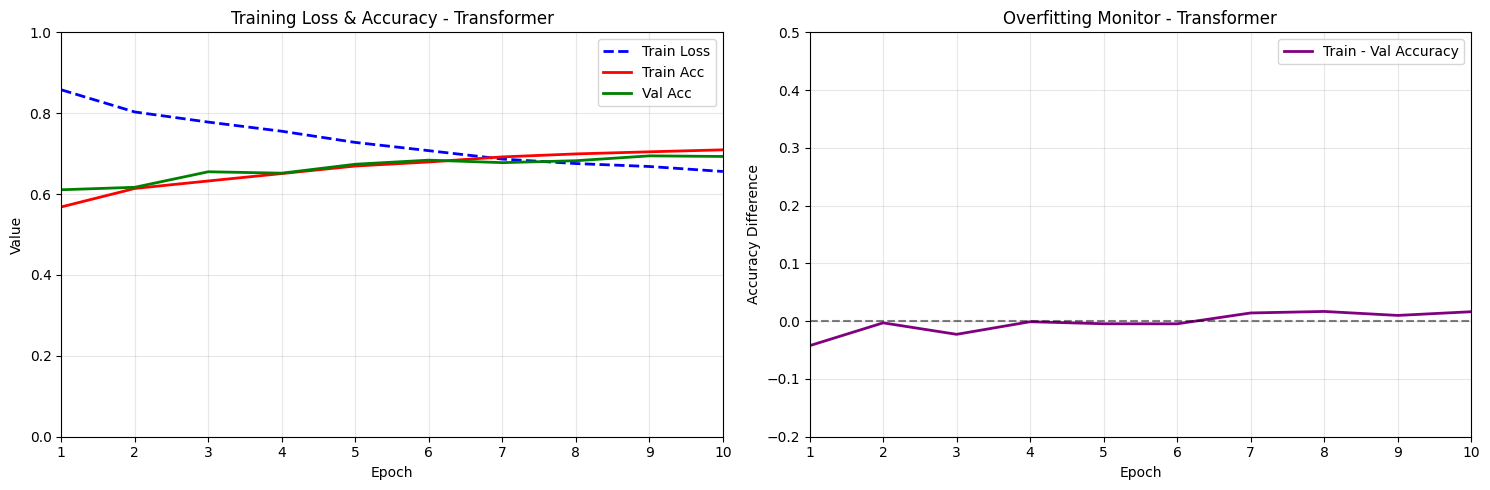


TRAINING SUMMARY
Model Name: Transformer
Final Train Loss: 0.6559
Final Train Accuracy: 0.7095
Final Val Loss: 0.6856
Final Val Accuracy: 0.6931
Best Val Accuracy: 0.6946 (Epoch 9)
Final Overfitting Gap: 0.0164


In [39]:
# 绘制训练曲线
plot_training_curves("Transformer", transformer_history)

# 打印训练摘要
print_training_summary("Transformer", transformer_history)

Testing: 100%|██████████| 58497/58497 [01:53<00:00, 516.06it/s]



TEST RESULTS
Model Name: Transformer
Test Accuracy: 0.6875
Test Precision (weighted): 0.6858
Test Recall (weighted): 0.6875
Test F1 Score (weighted): 0.6831

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7408    0.6445    0.6893     18605
     Neutral     0.5913    0.5211    0.5540     14749
    Positive     0.7006    0.8168    0.7543     25143

    accuracy                         0.6875     58497
   macro avg     0.6776    0.6608    0.6659     58497
weighted avg     0.6858    0.6875    0.6831     58497



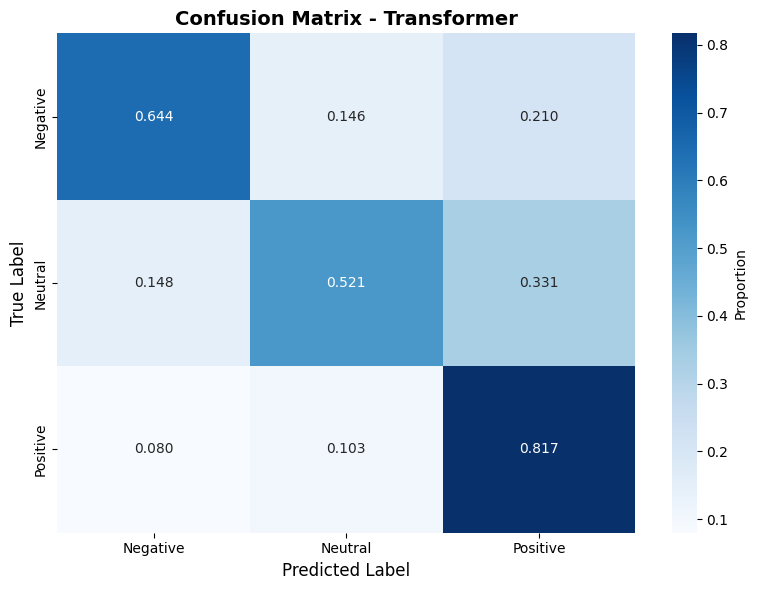


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7408, Recall=0.6445, F1=0.6893, Support=18605
 Neutral: Precision=0.5913, Recall=0.5211, F1=0.5540, Support=14749
Positive: Precision=0.7006, Recall=0.8168, F1=0.7543, Support=25143


In [40]:
# Transformer 测试过程 - 使用通用框架
transformer_test_results = test_model_comprehensive(
    model=transformer,
    model_name="Transformer",
    test_loader=test_data_loader_trans,
    device=device
)

In [41]:
# 保存Transformer训练结果
save_training_results(
    model=transformer,
    model_name="Transformer",
    set_epochs=num_epoch,
    actual_epochs=len(transformer_history['train_losses']),
    device=device,
    use_pretrained_embeddings=False,
    training_history=transformer_history,
    test_results=transformer_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: Transformer (Transformer)
  - 实际训练轮数: 10
  - 测试准确率: 0.6875
  - 测试F1分数: 0.6831
  - 记录时间: 2025-11-18 13:37:49
  - 总记录数: 35


In [42]:
# 模型性能比较
def compare_models(model_results, model_names=None):
    """
    比较多个模型的性能
    
    Args:
        model_results: 模型结果字典的列表
        model_names: 模型名称列表
    """
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(model_results))]
    
    # 创建比较表格
    import pandas as pd
    
    comparison_data = []
    for i, (name, result) in enumerate(zip(model_names, model_results)):
        comparison_data.append({
            'Model': name,
            'Accuracy': result['accuracy'],
            'Precision': result['precision'],
            'Recall': result['recall'],
            'F1 Score': result['f1']
        })
    
    df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(df.round(4).to_string(index=False))
    
    # 绘制比较图表
    plt.figure(figsize=(15, 5))
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metric_keys = ['accuracy', 'precision', 'recall', 'f1']  # 对应的字典键
    x = np.arange(len(model_names))
    width = 0.2
    
    plt.subplot(1, 2, 1)
    for i, (metric, key) in enumerate(zip(metrics, metric_keys)):
        values = [result[key] for result in model_results]
        plt.bar(x + i*width, values, width, label=metric, alpha=0.8)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + width*1.5, model_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.9)
    
    # F1分数单独比较
    plt.subplot(1, 2, 2)
    f1_scores = [result['f1'] for result in model_results]
    bars = plt.bar(model_names, f1_scores, alpha=0.8, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'][:len(model_names)])
    plt.xlabel('Models')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Comparison')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 0.9)
    
    # 在柱状图上显示数值
    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 找出最佳模型
    best_idx = np.argmax([result['f1'] for result in model_results])
    print(f"\nBest performing model: {model_names[best_idx]} (F1 Score: {model_results[best_idx]['f1']:.4f})")

# 使用示例（在所有模型都训练完成后运行）
model_results = [
    logreg_test_results,  # Logistic Regression
    mlp_test_results,  # MLP
    cnn_test_results,  # CNN  
    lstm_test_results,  # LSTM
    transformer_test_results  # Transformer
]
model_names = ['TF-IDF + LR', 'MLP', 'CNN', 'LSTM', 'Transformer']
# compare_models(model_results, model_names)